First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [74]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [75]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [76]:
executed_by ='stud-id_12205610'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [77]:
# group id for this project
group_id = '84'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12205610'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12129099'  # Replace the digits after "id_" with student B's student ID

In [78]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [79]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [80]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    'unit': 'http://qudt.org/vocab/unit/', # Added by student_a
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [81]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [82]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Jonathan" .',
f':{student_a} foaf:familyName "Maier" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12205610"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Fritz" .',
f':{student_b} foaf:familyName "Marvin" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12129099"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]

engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

## Business Understanding 

In [83]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [84]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
Scenario:       We founded the Company "Fritz & Maier AG" after our Bachelors, which is a software company that has scaled rapidly to hundreds of employees that are located all over the world. 
                Due to this rapid expansion, the current compensation structure is ad-hoc, resulting in internal pay inequities and potential misalignment with the current market. 
                As the company matures and growes even further, HR requires a data-driven approach to standardize these salaries. 
                The goal is to use the Stack Overflow data to analyze the relationship between skills, experience, and education against compensation to benchmark current employee salaries make adaptions for the following business year.

Data Source:    The analysis utilizes the Stack Overflow Annual Developer Survey 2025. 
                This dataset contains comprehensive information regarding developer demographics, experience, technology usage, and compensation from a global audience.

"""

business_objectives_comment = """
The primary objective is to establish a data-driven salary benchmarking model to find a fair market value for software engineering roles based on objective factors such as experience, location and their tech stack.

Secondary Objectives:
1. Identify current employees who may be significantly under- or overpaid compared to the market.
2. Standardize salary offers for new hires to reduce negotiation time.
3. Ensure the company's budget is optimized by avoiding arbitrary overpayment while maintaining competitiveness.
"""

business_success_criteria_comment = """
1. Salary Model Adoption: The HR department successfully adopts the model to review at least 80% of current employee contracts.
2. Turnover Reduction: A measurable reduction in staff turnover attributed to compensation issues.
3. Offer Acceptance: An increase in the acceptance rate of initial job offers for new hires, indicating that the data-backed offers are competitive.
5. Budget Optimization: Achieving a total salary budget that aligns within +/- 10% of the predicted market benchmark, ensuring the company is neither overspending nor significantly underpaying.
6. Faster Time-to-Hire: A reduction in the average time required to close a candidate, specifically by shortening the salary negotiation phase through transparent, data-backed offers.
"""

data_mining_goals_comment = """
The general overall goal of our data mining activites is to build a regression model which helps HR determine appropriate salaries for new employees. 
And in order to to that we take the for us most important pieces of data out of the Developer survey, divide it into different pieces of data categories and then start to transform the data.
Our second data mining goal is to identify employees that are significantly over- / underpaid in comparison to the market.
And our third goal is to identify which skills or attributes influences the salary of a developer the most. For this we do not only take the most prominent ones into account like the years of working experience,
but also attributes that seem not interesting at the first glance, for example the industry a developer is working in.
...
"""

data_mining_success_criteria_comment = """
### Source of how R^2 works: https://statisticsbyjim.com/regression/interpret-r-squared-regression/ ###
The first and most important data mining success criteria is to achieve a high accuracy regarding the salary predictions. Therefore we want to reach an R^2 of 80% minimum.
Our second goal is to have as less outliers as possible, in order to consider our model as robust. We consider an employee to be an outlier, if he has +/- 20% deviation of the initial model prediction.
Our third goal is to have a high data quality for our model, which means, that after all data cleansing we have less than 10% of missing data.
Our fourth goal is to make the model readable for the HR department. As this is a subjective criteria it has to be checked, whether the employees of the HR department are
able to properly read the model and take conclusions out of it. In order to guarantee that, the creators of the model validate the usage of the HR department.
...
"""

ai_risk_aspects_comment = """
Fairness & Ethics:
    -) The big advantage the chosen dataset has is that no differentiation between male and female developers has been made which means that the risk of the model building a bias in that regard is non existent.
    -) We also want to mitigate the risk of noisy or missing data as much as possible in order to also not have the potential problem of unreliability within the model.
    -) In our opinion the only possible problem / bias the model could have is the country that a developer is working in. 
Data quality:
    -) Even though, the stack overflow survey consists of a broad range of developers that were asked, it does not represent the global deveveloper population or their salaries.
    -) As the Fritz & Maier AG currently has their very own unique way of setting salaries, it may be possible, that the trained model strongly misaligns with the current salaries and therefore could be useless.
Documentation & Usage:
    -) Especially in fields like the salaries it is very important to have a high governance and documentation, in order to not only be compliant with the EU AI-Act, but also for the HR department to know, that the
       model can be used without having to think about biases at all.
...
"""

bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

In [85]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
    f':data_understanding_phase rdf:type prov:Activity .',
    f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


#### Data Schema and Layout
Before we dive deeper into the identified issues, the following section provides a brief overview of the data structure.

In [86]:
import re

survey_data_path = os.path.join("data", "stack-overflow-developer-survey-2025")
load_survey_data_code_writer = student_a
def load_survey_data()-> pd.DataFrame:
    ### Load your data
    input_file = os.path.join(survey_data_path, 'survey_results_public.csv')
    return pd.read_csv(input_file,  sep=',', header = 0, low_memory=False)

def load_survey_schema() -> pd.DataFrame:
    ### Load your data schema
    schema_file = os.path.join(survey_data_path, 'survey_results_schema.csv')
    return pd.read_csv(schema_file, sep=',', header=0, low_memory=False)
    
start_time_ld = now()
data = load_survey_data()
schema = load_survey_schema()
end_time_ld = now()

# show all columns for this display only
with pd.option_context('display.max_columns', None):
    print("Schema:")
    display(schema.head())
    print("\n\nData:")
    display(data.head())

#############################################
# Documentation 
# AI DISCLAIMER: I created a few documentations on my own assisted by Gemini.
# After a few exmples were created I used Gemini to generate the rest, while I was just then just adapting and correcting them.
# #############################################


# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "2fd35d2e-784c-4f18-be0f-cd78bba48813" # Generate once
load_survey_data_executor = [
    f':load_survey_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

ld_ass_uuid_writer = "68894ca0-0692-4e99-a19d-48b5263d941b" # Fixed UUID
ld_report = "Load Stack Overflow 2025 Survey Data and Schema CSVs into Pandas DataFrames."
load_survey_activity = [
    # Activity Definition
    ':load_survey_data rdf:type prov:Activity .',
    ':load_survey_data sc:isPartOf :data_understanding_phase .',
    ':load_survey_data rdfs:label "Load Survey Data" .',
    f':load_survey_data rdfs:comment """{ld_report}""" .',
    f':load_survey_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_survey_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    
    # Agent Association (Writer)
    f':load_survey_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_survey_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Inputs (The Files)
    ':load_survey_data prov:used :survey_csv_file .',
    ':load_survey_data prov:used :schema_csv_file .',
    
    # Outputs (The Loaded Data Entity)
    ':loaded_survey_data rdf:type prov:Entity .',
    ':loaded_survey_data prov:wasGeneratedBy :load_survey_data .',
    ':loaded_survey_data prov:wasDerivedFrom :survey_csv_file .',
]
engine.insert(load_survey_activity, prefixes=prefixes)

# 2. Define the File Assets (Croissant)
file_asset_triples = [
    # Main Data File
    ':survey_csv_file rdf:type cr:FileObject .',
    ':survey_csv_file sc:name "survey_results_public.csv" .',
    ':survey_csv_file sc:description "Raw survey responses from Stack Overflow 2025" .',
    ':survey_csv_file sc:encodingFormat "text/csv" .',
    
    # Schema File
    ':schema_csv_file rdf:type cr:FileObject .',
    ':schema_csv_file sc:name "survey_results_schema.csv" .',
    ':schema_csv_file sc:description "Metadata and question definitions" .',
    ':schema_csv_file sc:encodingFormat "text/csv" .',
]
engine.insert(file_asset_triples, prefixes=prefixes)

# 3. Define the Dataset Schema (Dynamic Generation)
dataset_triples = [
    ':loaded_survey_data rdf:type sc:Dataset .',
    ':loaded_survey_data sc:name "Stack Overflow Developer Survey 2025" .',
    ':loaded_survey_data sc:description "Public results of the annual developer survey." .',
    ':loaded_survey_data sc:distribution :survey_csv_file .',
    
    # Define the RecordSet
    ':survey_recordset rdf:type cr:RecordSet .',
    ':survey_recordset sc:name "Survey Responses" .',
    ':loaded_survey_data cr:recordSet :survey_recordset .',
]

# --- AUTOMATED FIELD GENERATION ---
for col_name in data.columns:
    # We replace anything that is NOT a letter, number, or underscore with an underscore
    safe_col_id = re.sub(r'[^a-zA-Z0-9_]', '_', col_name)
    field_node = f":field_{safe_col_id}"
    
    # Get description from Schema DF if available
    try:
        desc = "No description available"
        if col_name in schema['qname'].values:
            desc = schema.loc[schema['qname'] == col_name, 'question'].values[0]
        else:
            # Fallback for matrix sub-columns
            for q in sorted(schema['qname'].astype(str), key=len, reverse=True):
                if col_name.startswith(q):
                    desc = schema.loc[schema['qname'] == q, 'question'].values[0]
                    break
        
        # Clean text for RDF (Escape quotes and remove newlines)
        desc = desc.replace('"', "'").replace('\n', ' ')[:200]
    except:
        desc = "Description lookup failed"

    # Infer XSD Data Type from Pandas Dtype
    dtype = data[col_name].dtype
    xsd_type = "xsd:string"
    if pd.api.types.is_integer_dtype(dtype):
        xsd_type = "xsd:integer"
    elif pd.api.types.is_float_dtype(dtype):
        xsd_type = "xsd:double"
    elif pd.api.types.is_bool_dtype(dtype):
        xsd_type = "xsd:boolean"

    # Add Field Triples
    dataset_triples.append(f':survey_recordset cr:field {field_node} .')
    dataset_triples.append(f'{field_node} rdf:type cr:Field .')
    dataset_triples.append(f'{field_node} sc:name "{col_name}" .') # Keep original name here
    dataset_triples.append(f'{field_node} sc:description "{desc}" .')
    dataset_triples.append(f'{field_node} cr:dataType {xsd_type} .')

    # Add QUDT Units for specific columns
    if col_name == 'ConvertedCompYearly':
         dataset_triples.append(f'{field_node} qudt:unit unit:US_Dollar .')
    elif col_name in ['WorkExp', 'YearsCode']:
         dataset_triples.append(f'{field_node} qudt:unit unit:Year .')

# Insert the massive list of triples
engine.insert(dataset_triples, prefixes=prefixes)
print("Documentation complete: Survey Data loaded and schema defined.")

Schema:


,qid,qname,question,type,sub,sq_id
0,QID18,TechEndorse_1,What attracts you to a technology or causes you to endorse it (most to least important)?,RO,AI integration or AI Agent capabilities,1.0
1,QID18,TechEndorse_2,What attracts you to a technology or causes you to endorse it (most to least important)?,RO,Easy-to-use API,2.0
2,QID18,TechEndorse_3,What attracts you to a technology or causes you to endorse it (most to least important)?,RO,Robust and complete API,3.0
3,QID18,TechEndorse_4,What attracts you to a technology or causes you to endorse it (most to least important)?,RO,Customizable and manageable codebase,4.0
4,QID18,TechEndorse_5,What attracts you to a technology or causes you to endorse it (most to least important)?,RO,Reputation for quality,5.0




Data:


,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,AILearnHow,YearsCode,DevType,OrgSize,ICorPM,RemoteWork,PurchaseInfluence,TechEndorseIntro,TechEndorse_1,TechEndorse_2,TechEndorse_3,TechEndorse_4,TechEndorse_5,TechEndorse_6,TechEndorse_7,TechEndorse_8,TechEndorse_9,TechEndorse_13,TechEndorse_13_TEXT,TechOppose_1,TechOppose_2,TechOppose_3,TechOppose_5,TechOppose_7,TechOppose_9,TechOppose_11,TechOppose_13,TechOppose_16,TechOppose_15,TechOppose_15_TEXT,Industry,JobSatPoints_1,JobSatPoints_2,JobSatPoints_3,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,JobSatPoints_13,JobSatPoints_14,JobSatPoints_15,JobSatPoints_16,JobSatPoints_15_TEXT,AIThreat,NewRole,ToolCountWork,ToolCountPersonal,Country,Currency,CompTotal,LanguageChoice,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,LanguagesHaveEntry,LanguagesWantEntry,DatabaseChoice,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,DatabaseHaveEntry,DatabaseWantEntry,PlatformChoice,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,PlatformHaveEntry,PlatformWantEntry,WebframeChoice,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,WebframeHaveEntry,WebframeWantEntry,DevEnvsChoice,DevEnvsHaveWorkedWith,DevEnvsWantToWorkWith,DevEnvsAdmired,DevEnvHaveEntry,DevEnvWantEntry,SOTagsHaveWorkedWith,SOTagsWantToWorkWith,SOTagsAdmired,SOTagsHaveEntry,SOTagsWant Entry,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackHaveEntry,OfficeStackWantEntry,CommPlatformHaveWorkedWith,CommPlatformWantToWorkWith,CommPlatformAdmired,CommPlatformHaveEntr,CommPlatformWantEntr,AIModelsChoice,AIModelsHaveWorkedWith,AIModelsWantToWorkWith,AIModelsAdmired,AIModelsHaveEntry,AIModelsWantEntry,SOAccount,SOVisitFreq,SODuration,SOPartFreq,SO_Dev_Content,SO_Actions_1,SO_Actions_16,SO_Actions_3,SO_Actions_4,SO_Actions_5,SO_Actions_6,SO_Actions_9,SO_Actions_7,SO_Actions_10,SO_Actions_15,SO_Actions_15_TEXT,SOComm,SOFriction,AISelect,AISent,AIAcc,AIComplex,AIToolCurrently partially AI,AIToolDon't plan to use AI for this task,AIToolPlan to partially use AI,AIToolPlan to mostly use AI,AIToolCurrently mostly AI,AIFrustration,AIExplain,AIAgents,AIAgentChange,AIAgent_Uses,AgentUsesGeneral,AIAgentImpactSomewhat agree,AIAgentImpactNeutral,AIAgentImpactSomewhat disagree,AIAgentImpactStrongly agree,AIAgentImpactStrongly disagree,AIAgentChallengesNeutral,AIAgentChallengesSomewhat disagree,AIAgentChallengesStrongly agree,AIAgentChallengesSomewhat agree,AIAgentChallengesStrongly disagree,AIAgentKnowledge,AIAgentKnowWrite,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning new coding techniques or programming language","Online Courses or Certification (includes all media types);Other online resources (e.g. standard search, forum, online community)","Yes, I learned how to use AI-enabled tools for my personal curiosity and/or hobbies",AI CodeGen tools or AI-enabled apps,14.0,"Developer, mobile",20 to 99 employees,People manager,Remote,"Yes, I influenced the purchase of a substantial addition to the tech stack",Work,10.0,7.0,9.0,6.0,3.0,11.0,12.0,1.0,8.0,14.0,NaN,15.0,7.0,8.0,12.0,11.0,1.0,6.0,13.0,3.0,16.0,NaN,Fintech,3.0,1.0,4.0,9.0,5.0,10.0,12.0,11.0,2.0,6.0,7.0,13.0,14.0,15.0,8.0,NaN,I'm not sure,I have neither consider or transitioned into a new career or industry,7.0,3.0,Ukraine,EUR European Euro,52800.0,Yes,Bash/Shell (all shells);Dart;SQL,Dart,Dart,NaN,NaN,Yes,Cloud Firestore;PostgreSQL,NaN,NaN,NaN,NaN,Yes,Amazon Web Services (AWS);Cloudflare;Firebase;Google Cloud;Gradle,NaN

Documentation complete: Survey Data loaded and schema defined.


### Understanding the Question Schemas

To facilitate a systematic understanding of the dataset structure, we utilize the auxiliary `survey_results_schema.csv` file. This metadata file provides essential context for each column in the primary dataset, specifically defining the 'type' of question associated with each feature. By mapping these types to our data columns, we can categorize features into logical groups for appropriate analysis and preprocessing.

The schema identifies four primary question types:

1.  **Rank Order (RO):** Questions where respondents rank items by preference or importance (e.g., '1' = Most Important).
2.  **Matrix:** Questions allowing multiple selections from a list, often resulting in semicolon-separated string values.
3.  **Text Entry (TE):** Open-ended fields that may contain either unstructured free text or numeric input that requires cleaning.
4.  **Multiple Choice (MC):** Categorical questions where respondents select a single option from a predefined list.

In [87]:
# Group the schema by 'type' and print the column names for each
for q_type, group in schema.groupby('type'):
    cols = group['qname'].unique().tolist()
    print(f"\n### Question Type: {q_type} ({len(cols)} columns) ###")
    print(cols)


### Question Type: MC (48 columns) ###
['MainBranch', 'Age', 'EdLevel', 'Employment', 'EmploymentAddl', 'LearnCodeChoose', 'LearnCode', 'LearnCodeAI', 'AILearnHow', 'DevType', 'OrgSize', 'ICorPM', 'RemoteWork', 'PurchaseInfluence', 'TechEndorseIntro', 'Industry', 'JobSat', 'AIThreat', 'NewRole', 'Country', 'Currency', 'LanguageChoice', 'DatabaseChoice', 'PlatformChoice', 'WebframeChoice', 'DevEnvsChoice', 'AIModelsChoice', 'SOAccount', 'SOVisitFreq', 'SODuration', 'SOPartFreq', 'SO_Dev_Content', 'SOComm', 'SOFriction', 'AISelect', 'AISent', 'AIAcc', 'AIComplex', 'AIFrustration', 'AIAgents', 'AIAgentChange', 'AIAgent_Uses', 'AgentUsesGeneral', 'AIAgentKnowledge', 'AIAgentOrchestration', 'AIAgentObserveSecure', 'AIAgentExternal', 'AIHuman']

### Question Type: Matrix (13 columns) ###
['Language', 'Database', 'Platform', 'Webframe', 'DevEnvs', 'SOTags', 'OpSys', 'OfficeStackAsync', 'CommPlatform', 'AIModels', 'AITool', 'AIAgentImpact', 'AIAgentChallenges']

### Question Type: RO (49 colu

## Identifying Schema Mismatch
Unfortunately we relied on the correctness of the schema but then discovered late in the Data Understanding phase that its column list does not fully match the actual data's CSV header. So this misalignment has to be kept in mind whenever we reference the schema in later steps.

In [88]:
schema_columns = schema['qname'].tolist()
schema_column_set = set(schema_columns)
data_column_set = set(data.columns)

common_count = len(schema_column_set & data_column_set)
data_only_count = len(data_column_set - schema_column_set)
schema_only = [col for col in schema_columns if col not in data_column_set]

print(f"Number of columns in both schema and data: {common_count}")
print(f"Number of columns only in data: {data_only_count}")
print(f"Number of columns only in schema: {len(schema_only)}")

# --- Documentation ---
validation_summary = f"""
Schema Consistency Analysis:
- Common Columns: {common_count}
- Columns only in Data: {data_only_count}
- Columns only in Schema: {len(schema_only)}
"""

# Generated uuid
sc_check_uuid = "a1b2c3d4-e5f6-7890-1234-56789abcdef0" 
schema_check_triples = [
    # --- The Activity ---
    ':check_schema_consistency rdf:type prov:Activity .',
    ':check_schema_consistency rdfs:label "Check Schema vs Data Consistency" .',
    ':check_schema_consistency sc:isPartOf :data_understanding_phase .',
    f':check_schema_consistency prov:startedAtTime "{now()}"^^xsd:dateTime .',
    
    # Inputs
    ':check_schema_consistency prov:used :loaded_survey_data .',
    ':check_schema_consistency prov:used :schema_csv_file .',

    # --- The Agent Association (Who did it?) ---
    f':check_schema_consistency prov:qualifiedAssociation :{sc_check_uuid} .',
    f':{sc_check_uuid} rdf:type prov:Association .',
    f':{sc_check_uuid} prov:agent :{executed_by} .',
    f':{sc_check_uuid} prov:hadRole :{code_executor_role} .',

    # --- The Output (The Report Entity) ---
    ':schema_mismatch_report rdf:type prov:Entity .',
    ':schema_mismatch_report rdfs:label "Schema Consistency Report" .',
    f':schema_mismatch_report rdfs:comment """{validation_summary}""" .',
    ':schema_mismatch_report prov:wasGeneratedBy :check_schema_consistency .',
]

# 4. Insert into Graph
engine.insert(schema_check_triples, prefixes=prefixes)

Number of columns in both schema and data: 126
Number of columns only in data: 46
Number of columns only in schema: 13


### Temporary Preprocessing for Data Understanding

So far we have found out what types of information the columns store, but to do a more detailed analysis we have to do a short preprocessing, simplifying the foundation for the following steps. So in the following we will already apply some steps that would belong to the Data Preparation Part, but to narrow the focus of the Data Understanding, allowing more detail, these will already be applied here.

First of all, since the dataset feeds a regression model targeting the `ConvertedCompYearly` (salary) column, we drop every record missing that value. Then we also omit the open-ended questions to avoid manual or LLM-assisted analysis. There was an exception made for the columns: `YearsCode`, `CompTotal` and `WorkExp`, as these are clear numeric columns that can be converted.

Additionally multiple columns were dropped, as they dont seem relevant for our business case or contain subjective noise/meta-data that does not correlate strongly with salary. Due to the mismatch between the columns in the schema and in the actual dataset, we first went through the schmema to select the columns to drop, but then had to additionally go through the dataset to select the columns there as well. This is why there are potentially column names listed to be dropped, while not even existent in the csv.

#### Ranking Columns Disclaimer
The survey also included some ranking questions, which now have 15 columns each in the final dataset. The next section will handle those specifically, for now they are left in the dataset.

In [89]:
cols_to_drop_from_schema = [
    # --- AI & Learning (Noise/Opinion) ---
    'AIAgentChallenges', 'AIAgentChange', 'AIAgentImpact', 'AIAgent_Uses', 
    'AIAgents', 'AIExplain', 'AIFrustration', 'AILearnHow', 
    'AIModels', 'AIModelsChoice', 'AIThreat', 'AITool', 
    'AgentUsesGeneral', 'LearnCode', 'LearnCodeAI', 'LearnCodeChoose', 

    # --- Survey Metadata & S.O. Activity (Noise) ---
    'ICorPM', 'NewRole', 'PurchaseInfluence', 'ToolCountPersonal', 'ToolCountWork',
    'CommPlatform', 'SOAccount', 'SOComm', 'SODuration', 'SOFriction', 
    'SOPartFreq', 'SOTags', 'SOVisitFreq', 'SO_Dev_Content',
]

cols_to_drop_final = [
    # Leakage & ID
    'CompTotal', 'ResponseId', 'Currency',
    
    # Future/Sentiment (Want/Admired/Choice)
    'LanguageWantToWorkWith', 'LanguageAdmired', 'LanguageChoice',
    'DatabaseWantToWorkWith', 'DatabaseAdmired', 'DatabaseChoice',
    'PlatformWantToWorkWith', 'PlatformAdmired', 'PlatformChoice',
    'WebframeWantToWorkWith', 'WebframeAdmired', 'WebframeChoice',
    'DevEnvsWantToWorkWith', 'DevEnvsAdmired', 'DevEnvsChoice',
    'SOTagsWantToWorkWith', 'SOTagsAdmired', 'SOTagsHaveWorkedWith',
    'OfficeStackAsyncWantToWorkWith', 'OfficeStackAsyncAdmired', 'OfficeStackAsyncHaveWorkedWith',
    'CommPlatformWantToWorkWith', 'CommPlatformAdmired', 'CommPlatformHaveWorkedWith',
    'AIModelsWantToWorkWith', 'AIModelsAdmired', 'AIModelsHaveWorkedWith',
    
    # Personal & AI Noise
    'OpSysPersonal use', 
    'AIAcc', 'AIComplex', 'AIHuman','TechEndorseIntro',
    
    # Granular AI Tool/Agent columns
    'AIToolCurrently partially AI', "AIToolDon't plan to use AI for this task", 
    'AIToolPlan to partially use AI', 'AIToolPlan to mostly use AI', 'AIToolCurrently mostly AI',
    'AIAgentImpactSomewhat agree', 'AIAgentImpactNeutral', 'AIAgentImpactSomewhat disagree', 
    'AIAgentImpactStrongly agree', 'AIAgentImpactStrongly disagree',
    'AIAgentChallengesNeutral', 'AIAgentChallengesSomewhat disagree', 'AIAgentChallengesStrongly agree', 
    'AIAgentChallengesSomewhat agree', 'AIAgentChallengesStrongly disagree',
    'AIAgentKnowledge', 'AIAgentOrchestration', 'AIAgentObserveSecure', 'AIAgentExternal'
]

cols_to_drop = cols_to_drop_from_schema + cols_to_drop_final

# Create a dictionary to map column names to their question type from the schema
# This handles the fact that some data columns (like 'LanguageHaveWorkedWith') map to a 'qname' in schema (like 'Language')
schema_map = dict(zip(schema['qname'], schema['type']))
sorted_qnames = sorted(schema['qname'].astype(str).tolist(), key=len, reverse=True)

def get_col_type(col_name):
    if col_name in schema_map: return schema_map[col_name]
    for q in sorted_qnames:
        if col_name.startswith(q): return schema_map[q]
    return "Unknown"

# Apply type mapping
column_types = {col: get_col_type(col) for col in data.columns}

print("Data Loaded. Total Columns:", len(data.columns))
print("Example Type Mapping:", list(column_types.items())[:5])

keep_cols = []
drop_cols = []

# Numeric concepts hidden in Text Entry (TE) fields that we WANT
NUMERIC_KEYWORDS = ['YearsCode', 'WorkExp']

for col, q_type in column_types.items():
    if col == 'ConvertedCompYearly':
        keep_cols.append(col)
        continue
    
    # Drop explicit text inputs
    if '_TEXT' in col:
        drop_cols.append(col)
        continue

    if col in cols_to_drop:
        drop_cols.append(col)
        continue
        
    # Logic for Text Entry (TE)
    if q_type == 'TE':
        if any(k in col for k in NUMERIC_KEYWORDS):
            print(f"Keeping TE column as numeric: {col}")
            keep_cols.append(col) # It's likely numeric (e.g. YearsCode)
        else:
            drop_cols.append(col) # It's likely just comments/text
    else:
        keep_cols.append(col)

# Create the filtered dataframe for analysis
df_analysis = data[keep_cols].copy()

print(f"Dropped {len(drop_cols)} text columns.")
print(f"Retained {len(keep_cols)} columns for analysis.")

# Drop Rows explicitly
target_col = 'ConvertedCompYearly'
nan_target_mask = df_analysis[target_col].isna()
rows_dropped = int(nan_target_mask.sum())
rows_remaining = int((~nan_target_mask).sum())
print(f"Rows dropped due to NaN in {target_col}: {rows_dropped}")
print(f"Rows remaining after drop: {rows_remaining}")
salary_data = df_analysis.loc[~nan_target_mask, target_col]


with pd.option_context('display.max_columns', None):
    print(df_analysis.head(0))
    print(salary_data.head(10))


# --- Documentation of Column Selection Step ---
drop_columns_report = f"""
Columns Dropped for Analysis ({len(drop_cols)} total):
- {', '.join(drop_cols)}
Columns Retained for Analysis ({len(keep_cols)} total):
- {', '.join(keep_cols)}
"""

# --- Documentation ---
column_selection_uuid = "d4e5f6a7-b4c9-0127-4567-89abcdof0123"
column_selection_activity = "column_selection"
column_selection = [
    # --- The Activity ---
    f':{column_selection_activity} rdf:type prov:Activity .',
    f':{column_selection_activity} rdfs:label "Check Schema vs Data Consistency" .',
    f':{column_selection_activity} sc:isPartOf :data_understanding_phase .',
    f':{column_selection_activity} prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':{column_selection_activity} prov:wasAssociatedWith :{student_a} .',
    
    # Inputs
    f':{column_selection_activity} prov:used :loaded_survey_data .',
    f':{column_selection_activity} prov:used :schema_csv_file .',

    # --- The Agent Association (Who did it?) ---
    f':{column_selection_activity} prov:qualifiedAssociation :{column_selection_uuid} .',
    f':{column_selection_uuid} rdf:type prov:Association .',
    f':{column_selection_uuid} prov:agent :{executed_by} .',
    f':{column_selection_uuid} prov:hadRole :{code_executor_role} .',

    # --- The Output (The Report Entity) ---
    f':{column_selection_activity}_report rdf:type prov:Entity .',
    f':{column_selection_activity}_report rdfs:label "Schema Consistency Report" .',
    f':{column_selection_activity}_report rdfs:comment """{drop_columns_report}""" .',
    f':{column_selection_activity}_report prov:wasGeneratedBy :{column_selection_activity} .',
]

# 4. Insert into Graph
engine.insert(column_selection, prefixes=prefixes)

Data Loaded. Total Columns: 172
Example Type Mapping: [('ResponseId', 'Unknown'), ('MainBranch', 'MC'), ('Age', 'MC'), ('EdLevel', 'MC'), ('Employment', 'MC')]
Keeping TE column as numeric: WorkExp
Keeping TE column as numeric: YearsCode
Dropped 105 text columns.
Retained 67 columns for analysis.
Rows dropped due to NaN in ConvertedCompYearly: 25244
Rows remaining after drop: 23947
Empty DataFrame
Columns: [MainBranch, Age, EdLevel, Employment, EmploymentAddl, WorkExp, YearsCode, DevType, OrgSize, RemoteWork, TechEndorse_1, TechEndorse_2, TechEndorse_3, TechEndorse_4, TechEndorse_5, TechEndorse_6, TechEndorse_7, TechEndorse_8, TechEndorse_9, TechEndorse_13, TechOppose_1, TechOppose_2, TechOppose_3, TechOppose_5, TechOppose_7, TechOppose_9, TechOppose_11, TechOppose_13, TechOppose_16, TechOppose_15, Industry, JobSatPoints_1, JobSatPoints_2, JobSatPoints_3, JobSatPoints_4, JobSatPoints_5, JobSatPoints_6, JobSatPoints_7, JobSatPoints_8, JobSatPoints_9, JobSatPoints_10, JobSatPoints_11, Jo

#### Filtering Ranking Columns
As there are 15 columns for each Ranking question, this is a lot of noise and might put too much emphasize on the ranking while actually just being a small part of the survey. Therefore in this section we will find the 3 categories for each ranking question that have the highest correlation with the target column. For this we use "pearson" method, which calcualtes linear relationships.

In [90]:
target_col = 'ConvertedCompYearly'
groups = ["TechEndorse", "TechOppose", "JobSatPoints"]

df_analysis[target_col] = pd.to_numeric(df_analysis[target_col], errors='coerce')
df_clean = df_analysis.dropna(subset=[target_col]) # safety first

"""try:
    df_clean[target_col].corr(df_clean[target_col], method='spearman')
    corr_method = 'spearman'
    print("Using Spearman correlation (statistically better for rankings).")
except Exception:
    corr_method = 'pearson'
    print("Scipy not found. Using Pearson correlation (standard linear correlation).")"""

corr_method = 'pearson'

# Find top 3 each
final_selected_columns = []
for group in groups:
    print(f"\n--- Analyzing Group: {group} ---")
    
    # regex: starts with group name, ends with underscore and number (example 'TechEndorse_1')
    regex_pattern = f"^{group}_\d+$"
    group_cols = [c for c in df_clean.columns if re.match(regex_pattern, c)]
    
    if not group_cols:
        print(f"Warning: No columns found for group '{group}'")
        continue
        
    # Calculate correlation
    correlations = df_clean[group_cols].corrwith(df_clean[target_col], method=corr_method)
    top_3 = correlations.abs().sort_values(ascending=False).head(3)
    
    for col, score in top_3.items():
        actual_corr = correlations[col]
        print(f"  {col}: {actual_corr:.4f} (Abs: {score:.4f})")
        final_selected_columns.append(col)

print("\n" + "="*30)
print("FINAL COLUMNS TO KEEP")
print(final_selected_columns)


--- Analyzing Group: TechEndorse ---
  TechEndorse_8: -0.0191 (Abs: 0.0191)
  TechEndorse_6: 0.0130 (Abs: 0.0130)
  TechEndorse_4: 0.0064 (Abs: 0.0064)

--- Analyzing Group: TechOppose ---
  TechOppose_3: -0.0197 (Abs: 0.0197)
  TechOppose_9: -0.0171 (Abs: 0.0171)
  TechOppose_13: 0.0163 (Abs: 0.0163)

--- Analyzing Group: JobSatPoints ---
  JobSatPoints_11: -0.0477 (Abs: 0.0477)
  JobSatPoints_4: 0.0321 (Abs: 0.0321)
  JobSatPoints_6: 0.0257 (Abs: 0.0257)

FINAL COLUMNS TO KEEP
['TechEndorse_8', 'TechEndorse_6', 'TechEndorse_4', 'TechOppose_3', 'TechOppose_9', 'TechOppose_13', 'JobSatPoints_11', 'JobSatPoints_4', 'JobSatPoints_6']


#### Removing Ranking Columns that did not pass the top 3 Correlation Check
Now we can remove all the Ranking columsn for TechEndorse, TechOppose and JabSatPoints that are not within the top 3. As the SO_Actions Ranking is entirely irrelevant we drop all columns for this Ranking.

In [91]:
ranking_groups = ["TechEndorse", "TechOppose", "JobSatPoints", "SO_Actions"]
all_ranking_cols = []

for group in ranking_groups:
    # Matches 'TechEndorse_1', 'JobSatPoints_12', etc.
    regex_pattern = f"^{group}_\d+$"
    found = [c for c in df_analysis.columns if re.match(regex_pattern, c)]
    all_ranking_cols.extend(found)

columns_to_drop = list(set(all_ranking_cols) - set(final_selected_columns))

print(f"Total ranking columns found: {len(all_ranking_cols)}")
print(f"Keeping: {len(final_selected_columns)}")
print(f"Dropping: {len(columns_to_drop)}")

# 3. Drop the unused columns from the dataframe
df_reduced = df_analysis.drop(columns=columns_to_drop)

# Verify the result
print("\n--- Columns successfully dropped. ---")
print(f"Original shape: {df_analysis.shape}")
print(f"New shape:      {df_reduced.shape}")

# Optional: Check that your target and important non-ranking columns are still there
print(f"\nVerifying 'ConvertedCompYearly' is present: {'ConvertedCompYearly' in df_reduced.columns}")
print(f"Verifying 'YearsCode' is present: {'YearsCode' in df_reduced.columns}")

print("\n Final remaining number of columns:", len(df_reduced.columns))
with pd.option_context('display.max_columns', None):
    print(df_reduced.head(0))


# Set df_analysis for furtherer steps
df_analysis = df_reduced.copy()

# --- Documentation ---
ranking_report_text = f"""
Correlation Method: {corr_method}
Selected Top-3 Ranking Features:
{', '.join(final_selected_columns)}
Dropped Ranking Features:
{', '.join(columns_to_drop)}
"""

ranking_uuid = "f8a9b0c1-d2e3-4567-8901-23456abcdef7" 
ranking_activity = "select_ranking_features"
ranking_selection_triples = [
    f':{ranking_activity} rdf:type prov:Activity .',
    f':{ranking_activity} rdfs:label "Select Ranking Features via Correlation" .',
    f':{ranking_activity} sc:isPartOf :data_understanding_phase .',
    f':{ranking_activity} prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':{ranking_activity} prov:used :loaded_survey_data .',
    f':{ranking_activity} prov:wasAssociatedWith :{student_a} .',

    f':{ranking_activity} prov:qualifiedAssociation :{ranking_uuid} .',
    f':{ranking_uuid} rdf:type prov:Association .',
    f':{ranking_uuid} prov:agent :{executed_by} .',
    f':{ranking_uuid} prov:hadRole :{code_executor_role} .',

    f':ranking_feature_report rdf:type prov:Entity .',
    f':ranking_feature_report rdfs:label "Ranking Feature Selection Report" .',
    f':ranking_feature_report rdfs:comment """{ranking_report_text}""" .',
    f':ranking_feature_report prov:wasGeneratedBy :{ranking_activity} .',
]

engine.insert(ranking_selection_triples, prefixes=prefixes)

Total ranking columns found: 45
Keeping: 9
Dropping: 36

--- Columns successfully dropped. ---
Original shape: (49191, 67)
New shape:      (49191, 31)

Verifying 'ConvertedCompYearly' is present: True
Verifying 'YearsCode' is present: True

 Final remaining number of columns: 31
Empty DataFrame
Columns: [MainBranch, Age, EdLevel, Employment, EmploymentAddl, WorkExp, YearsCode, DevType, OrgSize, RemoteWork, TechEndorse_4, TechEndorse_6, TechEndorse_8, TechOppose_3, TechOppose_9, TechOppose_13, Industry, JobSatPoints_4, JobSatPoints_6, JobSatPoints_11, Country, LanguageHaveWorkedWith, DatabaseHaveWorkedWith, PlatformHaveWorkedWith, WebframeHaveWorkedWith, DevEnvsHaveWorkedWith, OpSysProfessional use, AISelect, AISent, ConvertedCompYearly, JobSat]
Index: []


## Point A - Semantic Types
The following steps involved certain compromises. Semantic types were determined through manual inspection, as we did not find a robust dynamic identifier. For the correlation analysis, only numeric columns were considered, since further analysis would require additional preprocessing. Finally, the plausibility checks focused on key numerical columns, as detailed below.

In [92]:
profiling_activity_id = "bb6a40f99d924f9fbdd2b65ef6a82da2"
start_time_profile = now()

# --- Point A ---
semantic_types = {
    "MainBranch": "Categorical",
    "Age": "Ordinal",
    "EdLevel": "Ordinal",
    "Employment": "Categorical",
    "EmploymentAddl": "Multi-Select",
    "WorkExp": "Numerical",
    "YearsCode": "Numerical",
    "DevType": "Categorical",
    "OrgSize": "Ordinal",
    "RemoteWork": "Categorical",
    "TechEndorse_4": "Numerical",
    "TechEndorse_6": "Numerical",
    "TechEndorse_8": "Numerical",
    "TechOppose_3": "Numerical",
    "TechOppose_9": "Numerical",
    "TechOppose_13": "Numerical",
    "Industry": "Categorical",
    "JobSatPoints_4": "Numerical",
    "JobSatPoints_6": "Numerical",
    "JobSatPoints_11": "Numerical",
    "Country": "Categorical",
    "LanguageHaveWorkedWith": "Multi-Select",
    "DatabaseHaveWorkedWith": "Multi-Select",
    "PlatformHaveWorkedWith": "Multi-Select",
    "WebframeHaveWorkedWith": "Multi-Select",
    "DevEnvsHaveWorkedWith": "Multi-Select",
    "OpSysProfessional use": "Multi-Select",
    "AISelect": "Ordinal",
    "AISent": "Ordinal",
    "AIComplex": "Ordinal",
    "ConvertedCompYearly": "Numerical",
    "JobSat": "Numerical"
}

attr_triples = []
for col in df_analysis.columns:
    # Create the triple (Point a)
    if(col not in semantic_types):
        raise ValueError(f"Semantic type for column '{col}' not defined.")
    attr_triples.append(f'{field_node} rdfs:comment "Semantic Type: {semantic_types[col]}" .')

## Point B - Overall Statistics

In [93]:
stats_dict = {}
for col in df_analysis.columns:
    # Basic metrics
    d_type = df_analysis[col].dtype
    
    # Find more advanced stats based on type
    if pd.api.types.is_numeric_dtype(d_type):
        skew = df_analysis[col].skew()
        kurt = df_analysis[col].kurtosis()
        mode_val = df_analysis[col].mode()[0] if not df_analysis[col].mode().empty else "N/A"
        variance = df_analysis[col].var()
        
        stats_dict[col] = {
            "mean": round(df_analysis[col].mean(), 2),
            "std": round(df_analysis[col].std(), 2),
            "var": round(variance, 2),
            "min": df_analysis[col].min(),
            "max": df_analysis[col].max(),
            "mode": mode_val,
            "skew": round(skew, 2),
            "kurtosis": round(kurt, 2)
        }

        print(f"Numeric stats for {col}: {stats_dict[col]}")
    else:
        # For categorical columns, describe() is better, but add unique counts
        desc = df_analysis[col].describe()
        stats_dict[col] = {
            "unique": int(desc['unique']),
            "top": desc['top'],
            "freq": int(desc['freq'])
        }

        print(f"Categorical stats for {col}: {stats_dict[col]}")

# Convert to JSON for the Knowledge Graph
stats_json = json.dumps(stats_dict, indent=0, default=str).replace('\n', ' ').replace('"', "'")

Categorical stats for MainBranch: {'unique': 6, 'top': 'I am a developer by profession', 'freq': 37467}
Categorical stats for Age: {'unique': 7, 'top': '25-34 years old', 'freq': 16519}
Categorical stats for EdLevel: {'unique': 8, 'top': 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)', 'freq': 20278}
Categorical stats for Employment: {'unique': 6, 'top': 'Employed', 'freq': 33750}
Categorical stats for EmploymentAddl: {'unique': 171, 'top': 'None of the above', 'freq': 18613}
Numeric stats for WorkExp: {'mean': np.float64(13.37), 'std': np.float64(10.8), 'var': np.float64(116.64), 'min': np.float64(1.0), 'max': np.float64(100.0), 'mode': np.float64(10.0), 'skew': np.float64(1.46), 'kurtosis': np.float64(4.29)}
Numeric stats for YearsCode: {'mean': np.float64(16.57), 'std': np.float64(11.79), 'var': np.float64(138.95), 'min': np.float64(1.0), 'max': np.float64(100.0), 'mode': np.float64(10.0), 'skew': np.float64(1.24), 'kurtosis': np.float64(2.69)}
Categorical stats for DevType: {'unique

## Point B - Correlation
Here we found out if columns heavily correlate with each other or dont propery correlate with the target.

In [94]:
import pandas as pd
import numpy as np
import json

# --- CONFIGURATION ---
target_col = 'ConvertedCompYearly' # <--- Your Target
collinear_threshold = 0.60         # Threshold for "significant" correlation
weak_target_threshold = 0.05       # Drop if correlation with target < 0.05
# ---------------------

# 1. Calculate Matrix
df_numeric = df_analysis.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()

# 2. Identify Weak Features
target_corrs = corr_matrix[target_col].drop(target_col)
weak_features = target_corrs[abs(target_corrs) < weak_target_threshold].index.tolist()

# 3. Identify Collinear Features & Prepare JSON
collinear_drops = set()
strong_corrs = {} # Dictionary for your JSON output

columns = corr_matrix.columns
for i in range(len(columns)):
    for j in range(i):
        col_i = columns[i]
        col_j = columns[j]
        
        if col_i == target_col or col_j == target_col: continue
            
        corr_val = corr_matrix.iloc[i, j]
        
        # Check threshold
        if abs(corr_val) > collinear_threshold:
            # A. Prepare data for JSON output
            key = f"{col_i} vs {col_j}"
            strong_corrs[key] = round(corr_val, 2)
            
            # B. Decide which to drop (Smart Drop)
            corr_i_target = abs(corr_matrix.loc[col_i, target_col])
            corr_j_target = abs(corr_matrix.loc[col_j, target_col])
            
            # Drop the one that is LESS predictive of the target
            feature_to_drop = col_i if corr_i_target < corr_j_target else col_j
            collinear_drops.add(feature_to_drop)

# --- OUTPUT ---

print(f"--- 1. WEAK SIGNAL (Corr < {weak_target_threshold} with Target) ---")
print(f"ACTION: Drop these {len(weak_features)} columns.")
print(weak_features)

print("\n" + "="*60 + "\n")

print(f"--- 2. MULTICOLLINEARITY (Corr > {collinear_threshold}) ---")
print(f"ACTION: Drop these {len(collinear_drops)} columns (Keep the better partner).")
print(list(collinear_drops))

print("\n--- JSON OUTPUT ---")
# Your requested format:
corr_json = json.dumps(strong_corrs, indent=0).replace('\n', ' ').replace('"', "'")
print(corr_json)

--- 1. WEAK SIGNAL (Corr < 0.05 with Target) ---
ACTION: Drop these 10 columns.
['TechEndorse_4', 'TechEndorse_6', 'TechEndorse_8', 'TechOppose_3', 'TechOppose_9', 'TechOppose_13', 'JobSatPoints_4', 'JobSatPoints_6', 'JobSatPoints_11', 'JobSat']


--- 2. MULTICOLLINEARITY (Corr > 0.6) ---
ACTION: Drop these 1 columns (Keep the better partner).
['WorkExp']

--- JSON OUTPUT ---
{ 'YearsCode vs WorkExp': 0.84 }


## Point C - Plausibility and Quality

In [95]:
quality_report = {}

# Missing values
missing_counts = df_analysis.isna().sum()
quality_report["missing_values"] = missing_counts[missing_counts > 0].to_dict()

# Plausibility Checks
plausibility_flags = []
if 'ConvertedCompYearly' in df_analysis.columns:
    salary = df_analysis['ConvertedCompYearly']
    if (salary > 1000000).any():
        plausibility_flags.append(f"Target: Found {(salary > 1000000).sum()} salaries > 1M")
    if (salary < 100).any():
        plausibility_flags.append(f"Target: Found {(salary < 100).sum()} salaries < 100")

if 'WorkExp' in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis['WorkExp']):
    we = df_analysis['WorkExp']
    if (we < 0).any():
        plausibility_flags.append("Implausible: Negative WorkExp found")
    if (we > 60).any():
        plausibility_flags.append(f"Suspicious: {(we > 60).sum()} people with > 60 years WorkExp")

if 'YearsCode' in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis['YearsCode']):
    yc = df_analysis['YearsCode']
    if (yc > 60).any():
        plausibility_flags.append(f"Suspicious: {(yc > 60).sum()} people with > 60 YearsCode")

quality_report["plausibility_alerts"] = plausibility_flags
quality_report["total_rows"] = len(df_analysis)
quality_json = json.dumps(quality_report, indent=0).replace('\n', ' ').replace('"', "'")

end_time_profile = now()

### Documentation previous Activities

In [96]:
profiling_query = [
    f':{profiling_activity_id} rdf:type prov:Activity .',
    f':{profiling_activity_id} rdfs:label "Automated Data Profiling" .',
    f':{profiling_activity_id} sc:isPartOf :data_understanding_phase .',
    f':{profiling_activity_id} prov:startedAtTime "{start_time_profile}"^^xsd:dateTime .',
    f':{profiling_activity_id} prov:endedAtTime "{end_time_profile}"^^xsd:dateTime .',
    f':{profiling_activity_id} prov:used :loaded_survey_data .',
    f':{profiling_activity_id} prov:wasAssociatedWith :{student_a} .',

    # Log the Results (Points b & c)
    f':loaded_survey_data rdfs:comment """STATS: {stats_json}""" .',
    f':loaded_survey_data rdfs:comment """CORRELATIONS: {corr_json}""" .',
    f':loaded_survey_data rdfs:comment """CORRELATIONS Disclaimer: Despite the low correlation of the Ranking Columns we still keep them because combined they might provide a useful signal. We will also keep WorkEpxerience for now and see if this provides any issues for the Model.""" .',
    f':loaded_survey_data rdfs:comment """QUALITY: {quality_json}""" .',
]
# Add attribute semantics (Point a)
profiling_query.extend(attr_triples)

engine.insert(profiling_query, prefixes=prefixes)

## General Data Behaviour/Structure
Now that we are familiar with the Data Schema, in the following the overall distributions of the columns is shown. There will be a more detailed examination of the target column `ConvertedCompYearly`. The findings here were especially used for the outlier report, following this.

In [97]:
import seaborn as sns

sns.set_theme(style="whitegrid")
print("--- Generating Individual Distribution Plots ---")

for col in df_analysis.columns:
    if df_analysis[col].dropna().empty:
        continue
        
    plt.figure(figsize=(10, 5)) 
    
    # 1. Numeric Data (Histogram + Boxplot)
    if pd.api.types.is_numeric_dtype(df_analysis[col]):
        plt.subplot(1, 2, 1)
        sns.histplot(df_analysis[col].dropna(), kde=True, color='skyblue')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_analysis[col].dropna(), color='lightgreen')
        plt.title(f"{col} - Boxplot")
        
        skew = df_analysis[col].skew()
        print(f"{col}: Numeric | Skew: {skew:.2f}")

    # 2. Categorical / Object Data (Bar Chart)
    else:
        # Get top 15 categories to prevent to many data points
        top_counts = df_analysis[col].value_counts().nlargest(15)
        
        sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=top_counts.index, legend=False)
        plt.title(f"{col} - Top 15 Categories")
        plt.xlabel("Count")
        
        print(f"{col}: Categorical | Unique Values: {df_analysis[col].nunique()}")

    plt.tight_layout()
    # Save the plot to the specified directory
    plot_path = os.path.join("data", "visual_analysis")
    os.makedirs(plot_path, exist_ok=True)
    plt.savefig(os.path.join(plot_path, f"{col}_distribution.png"))
    # plt.show()
    plt.close()

--- Generating Individual Distribution Plots ---
MainBranch: Categorical | Unique Values: 6
Age: Categorical | Unique Values: 7
EdLevel: Categorical | Unique Values: 8
Employment: Categorical | Unique Values: 6
EmploymentAddl: Categorical | Unique Values: 171
WorkExp: Numeric | Skew: 1.46
YearsCode: Numeric | Skew: 1.24
DevType: Categorical | Unique Values: 32
OrgSize: Categorical | Unique Values: 9
RemoteWork: Categorical | Unique Values: 5
TechEndorse_4: Numeric | Skew: -0.10
TechEndorse_6: Numeric | Skew: -0.00
TechEndorse_8: Numeric | Skew: 0.45
TechOppose_3: Numeric | Skew: -0.06
TechOppose_9: Numeric | Skew: 0.78
TechOppose_13: Numeric | Skew: 0.21
Industry: Categorical | Unique Values: 15
JobSatPoints_4: Numeric | Skew: -0.59
JobSatPoints_6: Numeric | Skew: -0.16
JobSatPoints_11: Numeric | Skew: 0.54
Country: Categorical | Unique Values: 177
LanguageHaveWorkedWith: Categorical | Unique Values: 15478
DatabaseHaveWorkedWith: Categorical | Unique Values: 6670
PlatformHaveWorkedWith

#### ConvertedCompYear Inspection
In this part we will now have a closer look at the target column.

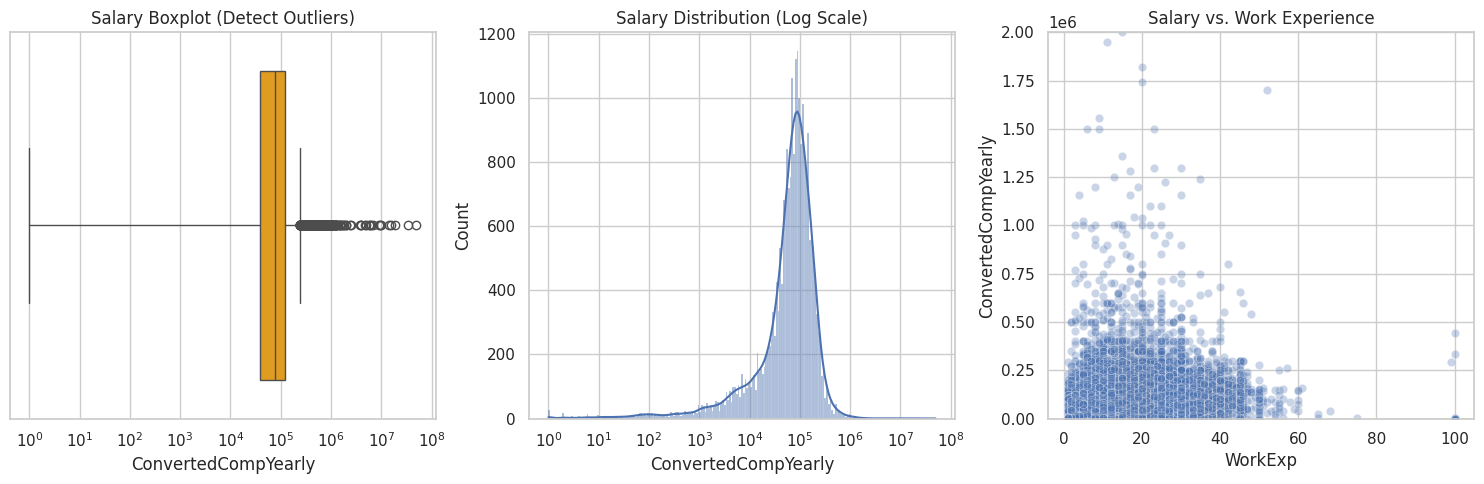

In [98]:
target_col = 'ConvertedCompYearly'
salary_data = df_analysis.loc[~nan_target_mask, target_col]

plt.figure(figsize=(15, 5))

# 1. Boxplot for Outliers
plt.subplot(1, 3, 1)
sns.boxplot(x=salary_data, color='orange')
plt.title("Salary Boxplot (Detect Outliers)")
plt.xscale('log') # Log scale helps visualize income better

# 2. Histogram for Distribution
plt.subplot(1, 3, 2)
sns.histplot(salary_data, kde=True, log_scale=True)
plt.title("Salary Distribution (Log Scale)")

# 3. Plausibility Check (Scatter vs Experience)
df_analysis['WorkExp'] = pd.to_numeric(df_analysis['WorkExp'], errors='coerce')
plt.subplot(1, 3, 3)
sns.scatterplot(x=df_analysis['WorkExp'], y=salary_data, alpha=0.3)
plt.title("Salary vs. Work Experience")
plt.ylim(0, 2000000) # Limit y-axis to see the bulk of data, ignoring massive outliers for view

plt.tight_layout()
plt.show()

## Visual Exploration Documentation(Point d)
So now we have visually explored the data. Below, the most important findings are briefly summarized and discussed.

In [99]:
# --- 2. LOGGING: Visual Exploration (Point d) ---
visual_interpretation = """
d. Visual Exploration Findings (Comprehensive):
   1. Target Variable ('ConvertedCompYearly'): 
      - Extreme right-skewed distribution. Boxplots confirm massive outliers (> $50M).
      - Action: Requires Log transformation and/or IQR outlier clipping (e.g., capping at 99th percentile) before Linear Regression.
   
   2. Systemic Multi-Label Complexity: 
      - Features: 'Language', 'Platform', 'Webframe', 'OpSys', 'DevEnvs' are ALL semicolon-separated strings.
      - Dominance: 'React', 'Node.js', and 'AWS' are dominant but often appear in combinations (e.g., "Next.js;Node.js;React").
      - Action: Simple one-hot encoding is insufficient; we must perform string splitting/tokenization to capture individual technologies.

   3. Professional Filtering ('MainBranch'):
      - The category "I am a developer by profession" vastly outweighs others (students, hobbyists).
      - Action: To ensure regression quality for salary prediction, we should filter the dataset to include ONLY professional developers.

   4. Ordinal & Likert Scale Features:
      - 'OrgSize': Categorical but ordinal (ranges from "Just me" to "10,000+ employees"). Should be encoded numerically to preserve rank.
      - Sentiment/Likert ('JobSatPoints', 'TechEndorse', 'TechOppose'): These display discrete, "spiky" distributions at integer intervals. While technically ordinal, they can often be treated as continuous features in regression models to capture trends.
      - 'JobSat': Left-skewed (peaking at 7-8), indicating a generally satisfied workforce.

   5. Industry & Environment:
      - 'Industry': Heavily skewed towards "Software Development". Other sectors (Fintech, Healthcare) are present but much smaller.
      - 'RemoteWork': "Remote" and "Hybrid" are the norms; "In-person" is a distinct minority.
      - 'OpSys': High prevalence of "Windows Subsystem for Linux (WSL)", indicating that OS usage is no longer binary (Windows vs. Linux) but often hybrid.

   6. Experience vs. Salary:
      - 'WorkExp' and 'YearsCode' are right-skewed (peaking ~5-10 years) but have long tails.
      - Boxplots show realistic outliers (e.g., 40+ years experience), unlike Salary which has unrealistic extremes.
"""

vis_activity_id = "0a82efc5-8a98-41e2-b3ba-33973a0e6186"

vis_query = [
    f':{vis_activity_id} rdf:type prov:Activity .',
    f':{vis_activity_id} rdfs:label "Visual Exploration of Data" .',
    f':{vis_activity_id} sc:isPartOf :data_understanding_phase .',
    f':{vis_activity_id} prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':{vis_activity_id} prov:wasAssociatedWith :{student_a} .',
    f':{vis_activity_id} prov:used :loaded_survey_data .',
    
    f':visual_report_{vis_activity_id} rdf:type prov:Entity .',
    f':visual_report_{vis_activity_id} rdfs:label "Visual Interpretation Report" .',
    f':visual_report_{vis_activity_id} rdfs:comment """{visual_interpretation}""" .',
    f':visual_report_{vis_activity_id} prov:wasGeneratedBy :{vis_activity_id} .',
]

engine.insert(vis_query, prefixes=prefixes)
print("Visual Exploration Interpretation logged.")

Visual Exploration Interpretation logged.


### Advanced Outlier Report
The visual Exploration of the data allows us to identify the necessary outlier detection actions based on the nature of the data. While most of the columns simply require a Frequence Threshold (kepping top n categories, groupnig remaining entries in "others") or to drop some categories, the numerical columns such as `ConvertedCompYearly`, `WorkExp` and `YearsCode`, are the ones that require additional attention to find the outliers.

In Additiona to the previous Findings, this Section does an in depth Outlier report. For the outlier detection we use the IQR Method as the Z-Score assumes a Bell-Curve, which does not fit in our case, as the columns checked here are not normally distributed but heavily right skewed.

In [100]:
check_outliers_code_writer = student_a

# Updated list of columns to check
cols_to_check = ["ConvertedCompYearly", 'WorkExp', 'YearsCode']
print(cols_to_check)

def check_outliers(data: pd.DataFrame, col: str) -> dict:
    tmp = data.copy() # work on copy
    
    # Coerce to numeric (errors='coerce' turns non-numbers to NaN)
    values = pd.to_numeric(tmp[col], errors='coerce')
    valid = values.dropna()
    
    if valid.empty:
        return {}

    # --- IQR CALCULATION ---
    Q1 = valid.quantile(0.25)
    Q3 = valid.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers_mask = (values < lower_bound) | (values > upper_bound)
    outliers_idx = values[outliers_mask].index
    
    # Store outlier details
    outlier_list = [
        {
            'index': int(idx),
            'value': float(values.loc[idx]),
            'reason': 'High' if values.loc[idx] > upper_bound else 'Low'
        }
        for idx in outliers_idx
    ]
    
    return {
        'outliers': outlier_list,
        'stats': {
            'Q1': float(Q1), 
            'Q3': float(Q3), 
            'IQR': float(IQR), 
            'Upper_Cutoff': float(upper_bound),
            'Lower_Cutoff': float(lower_bound)
        }
    }

# Check for all specified columns
start_time_co = now()
outliers_report = {}
for col in cols_to_check:
    if col not in df_analysis.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame.")

    result = check_outliers(df_analysis, col)
    if result:
        outliers_report[col] = result['outliers']
        outliers_report[f'{col}_stats'] = result['stats']
            
        # Print for immediate feedback
        count = len(result['outliers'])
        limit = result['stats']['Upper_Cutoff']
        print(f"[{col}] Found {count} outliers (Cutoff > {limit:,.2f})")

end_time_co = now()


# --- DOCUMENTATION ---
co_ass_uuid = "4120be38-c4ad-4f8f-a1cd-b6e6df3011a3" # UUID for Detection
# UPDATED: Extended notes on Categoricals and Ordinals based on visual inspection
co_comment = """
Outlier Findings from Visual Inspection & Detection Strategy:
1. ConvertedCompYearly (Target): Visual analysis showed extreme right-skewness with a massive spike near zero and a long tail extending to 50M. IQR is applied to remove these extremes to prevent regression coefficients from being dominated by outliers.
2. WorkExp & YearsCode (Features): Histograms revealed a right-skewed distribution. Boxplots identified values > ~40-50 years as statistical outliers. While physically possible, these high-leverage points can skew the slope of linear models and are removed via IQR.
3. Note on Categoricals: High cardinality and rare labels were observed in DevType, Country, and Industry (long tails), while MainBranch shows extreme imbalance. These will be handled in the Data Preparation phase via Frequency Thresholding (grouping rare labels into 'Other') or Binary Grouping, rather than statistical outlier removal.
4. Note on Ordinals: Low values in JobSat (0-2) are confirmed as valid negative sentiment, not errors, and will be retained. However, non-informative labels found in ordinal columns (e.g., 'I don't know' in OrgSize, 'Prefer not to say' in Age) are flagged for exclusion or imputation during Data Preparation.
5. Note on Ranked Features: This has already been done. The columns with highest correlation to the target were retained, while weakly correlated ranking features were dropped. These can stay as is for modeling.
"""

report_json = json.dumps(outliers_report).replace('"', "'")

check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:label "Check for Outliers (IQR)" .',
    f':check_outliers rdfs:comment """{co_comment}""" .', 
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    
    # Inputs
    ':check_outliers prov:used :loaded_survey_data .',

    # Executor
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid} .',
    f':{co_ass_uuid} rdf:type prov:Association .',
    f':{co_ass_uuid} prov:agent :{executed_by} .',
    f':{co_ass_uuid} prov:hadRole :{code_executor_role} .',

    # Output Report
    ':outlier_report rdf:type prov:Entity .',
    ':outlier_report rdfs:label "Outlier Detection Report" .',
    f':outlier_report rdfs:comment """{report_json}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
]
engine.insert(check_outliers_activity, prefixes=prefixes)


# --- B. Activity: INSPECT & DECIDE ---
ior_ass_uuid = "3cb16479-de42-4f70-9f4b-3ee25c371db9" # UUID for Inspection
ior_comment = """
Inspection & Decision Log:
1. Numerical Columns (Action: Remove Outliers):
   - ConvertedCompYearly, WorkExp, YearsCode: The calculated IQR thresholds successfully isolate extreme skew and high-leverage points (>50 years exp, >50M salary). Decision is to REMOVE these rows immediately to ensure regression stability.

2. Ordinal Columns (Action: Filter/Keep in Data Prep):
   - JobSat: Low values (0-2) are valid sentiment. Decision: KEEP.
   - OrgSize: 'I don't know' provides no utility. Decision: Flag for REMOVAL.
   - Age: 'Prefer not to say' is non-informative. Decision: Flag for REMOVAL.

3. Categorical Columns (Action: Grouping in Data Prep):
   - Country, DevType, Industry, EmploymentAddl: Long tails confirmed. Decision: Apply Frequency Thresholding (Group rare labels into 'Other').
   - MainBranch: Extreme imbalance. Decision: Binary Grouping (Pro vs. Non-Pro).
"""

inspect_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report sc:isPartOf :data_understanding_phase .',
    ':inspect_outlier_report rdfs:label "Inspect and Decide on Outliers" .',
    f':inspect_outlier_report rdfs:comment """{ior_comment}""" .',
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    
    # Input
    ':inspect_outlier_report prov:used :outlier_report .',

    # Executor
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid} .',
    f':{ior_ass_uuid} rdf:type prov:Association .',
    f':{ior_ass_uuid} prov:agent :{student_a} .',
    f':{ior_ass_uuid} prov:hadRole :{code_executor_role} .',

    # Output Decision
    ':outlier_decision rdf:type prov:Entity .',
    ':outlier_decision rdfs:label "Decision: Remove Num. Outliers & Defer Grouping" .',
    ':outlier_decision rdfs:comment "Action: Remove IQR outliers for Target/Numerical features. Also important is the removal of non-informative labels (Age/OrgSize) and categorical grouping to Data Preparation phase." .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
]
engine.insert(inspect_activity, prefixes=prefixes)

print("Outlier detection and decision logic updated.")

['ConvertedCompYearly', 'WorkExp', 'YearsCode']
[ConvertedCompYearly] Found 1062 outliers (Cutoff > 244,233.50)
[WorkExp] Found 608 outliers (Cutoff > 42.50)
[YearsCode] Found 413 outliers (Cutoff > 48.00)
Outlier detection and decision logic updated.


## Manual Qualitative Assessment (Points e, f, g)

In [101]:
assess_activity_id = "d0c7d6a1-1f6c-4d1e-9b58-0b7d8e4bfebb"

# --- 1. CLEAN TEXT CONTENT ---
# We strip out potential problem characters (like LaTeX arrows) and use standard ASCII
# The graph doesn't render LaTeX anyway, so standard text is better.

ethical_text = """
e. Ethical & Bias Evaluation:
   A major ethical issue is whether broad survey data is suitable for predicting an individual's salary. Surveys look at general statistics and often miss a person's unique situation. If we use this model for real-world pay decisions, we risk unfairly capping the salary of employees who don't fit the "average" profile, which could negatively impact their livelihoods.
   We also see bias regarding geography and money. The data clusters respondents from countries like Ukraine (using UAH) versus Western nations (using USD or EUR).
   If the model doesn't account for the cost of living differences, it might unfairly rate senior developers from these regions as "low value." There is also a risk of ageism because the data lumps everyone over 65 into one group, which might make the model think older people use less technology.
   Finally, prioritizing formal degrees like a Master's over self-taught skills could unfairly penalize experienced developers who didn't go to university.
"""

risk_text = """
f. Risks & External Questions:
   A fundamental risk is that we cannot verify if survey respondents are telling the truth. Self-reported data often contains exaggerated claims or "liars," and this dishonesty might correlate with specific locations or age groups, creating hidden biases we cannot easily detect.
   Financially, the 'CompTotal' column is very risky because it mixes local currencies—some people report in thousands (EUR) and others in millions (UAH). Because these numbers are incomparable, 'CompTotal' will not be part of our final dataset.
   We must rely on 'ConvertedCompYearly' instead, but this value is missing for many users (like students), which creates gaps in our data.
   Subjective questions also pose a risk; for example, a person's fear of AI might skew their answers about productivity.
"""

action_plan_text = """ g. Preparation Action Plan:
    The data preparation strategy begins with removing rows where the target variable ConvertedCompYearly is missing, as imputing salary would introduce unacceptable noise for the business objective.
    We will also remove the CompTotal and Currency columns to prevent multicollinearity and magnitude errors once the converted salary is confirmed.
    For cleaning, we must filter outliers in YearsCode, converting string descriptions into numeric values.
    Imputation will be applied to WorkExp using the median experience of corresponding age groups, and missing values in Likert-scale columns like TechEndorse will be assumed to indicate no endorsement.
    Feature engineering will focus on splitting semicolon-delimited strings in LanguageHaveWorkedWith into multi-hot encoded boolean flags.
    Finally, we will reduce high cardinality in the Country column by binning nations into broader regions and convert ordinal OrgSize ranges into numeric estimates to facilitate correlation analysis.

    Summary:
    - Remove Columns on Personal Decisions: So as there are many columns, which are most likely irreleavnt to the target variable, we decided to removed many of them.
    - Remove Columns due to Correlation: From these pre selected columns, we further removed columns, which had low correlation with the target variable. Allthough 'YearsCode' and 'WorkExp' had low correlation, we kept them due to their domain relevance. We also kept the Ranking columns despite low correlation to the target, as combined they may provide useful signal.
    - Target Cleaning: Remove rows missing 'ConvertedCompYearly' to ensure valid regression targets.
    - Outlier Removal: Apply IQR method to 'ConvertedCompYearly' and 'YearsCode' to remove extreme values.
    - Imputation: Fill missing 'WorkExp' using age-group medians; set null 'TechEndorse' to 0.
    - Changing Ranking Orders: For columns that belong to a ranking group (e.g. TechEndorse_1, TechEndorse_2, ...), we have to inverse the order, so that higher values indicate stronger endorsement.
    - Ordinal Encoding: For Ordinal columns like 'OrgSize', map ranges to numeric points that represent the order.
    - Norminal Encoding: For Categorical columns like 'Country', reduce cardinality by only using the top N countries and group the rest into "Others".
    - Mutli-Select Encoding: For Mutli-Select columns like 'LanguageHaveWorkedWith', split semicolon-delimited strings into separate boolean columns for each language.
    - Scale: Apply a Scaler to all numeric features to ensure that features with larger magnitudes do not disproportionately influence the Linear Regression weights.
"""

# Serialize to safe JSON strings (adds quotes and escapes newlines automatically)
# This prevents syntax errors in the SPARQL query.
ethical_safe = json.dumps(ethical_text)[1:-1] # [1:-1] removes the outer quotes added by json.dumps
risk_safe = json.dumps(risk_text)[1:-1]
action_safe = json.dumps(action_plan_text)[1:-1]


# --- 2. GENERATE NEW ID ---
current_time = now()

assess_query = [
    f':{assess_activity_id} rdf:type prov:Activity .',
    f':{assess_activity_id} rdfs:label "Qualitative Assessment" .',
    f':{assess_activity_id} sc:isPartOf :data_understanding_phase .',
    f':{assess_activity_id} prov:wasAssociatedWith :{student_a} .',
    f':{assess_activity_id} prov:startedAtTime "{current_time}"^^xsd:dateTime .',
    
    # Point e: Ethics
    f':report_ethics_{assess_activity_id} rdf:type prov:Entity .',
    f':report_ethics_{assess_activity_id} rdfs:comment "{ethical_safe}" .', # Use single quotes with safe text
    f':report_ethics_{assess_activity_id} prov:wasGeneratedBy :{assess_activity_id} .',

    # Point f: Risks
    f':report_risks_{assess_activity_id} rdf:type prov:Entity .',
    f':report_risks_{assess_activity_id} rdfs:comment "{risk_safe}" .',
    f':report_risks_{assess_activity_id} prov:wasGeneratedBy :{assess_activity_id} .',

    # Point g: Action Plan
    f':report_actions_{assess_activity_id} rdf:type prov:Entity .',
    f':report_actions_{assess_activity_id} rdfs:comment "{action_safe}" .',
    f':report_actions_{assess_activity_id} prov:wasGeneratedBy :{assess_activity_id} .',
]

engine.insert(assess_query, prefixes=prefixes)
print(f"✅ Qualitative Assessment logged with ID: {assess_activity_id}")

✅ Qualitative Assessment logged with ID: d0c7d6a1-1f6c-4d1e-9b58-0b7d8e4bfebb


## Data Preparation

### Example

In [ ]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [ ]:
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    # REMOVE OUTLIERS
    return df

start_time_td = now()
handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

### Performing pre-processing steps

In [ ]:
# This cell is used only for the creation and afterwards copying uuids in order to be able to fullfill the provenance.
import uuid
print(str(uuid.uuid4()))

In [102]:
#Deleting unnecessary columns:
cols_to_remove = columns_to_drop + cols_to_drop_final + cols_to_drop_from_schema
existing_cols = [col for col in cols_to_remove if col in data.columns]

# Drop all columns that are in "data" but not in "df_analysis"
cols_to_remove = [col for col in data.columns if col not in df_analysis.columns]
processed_data = data.drop(columns=cols_to_remove)
print("Remaining columns after removal:")
print(processed_data.columns.tolist())


Remaining columns after removal:
['MainBranch', 'Age', 'EdLevel', 'Employment', 'EmploymentAddl', 'WorkExp', 'YearsCode', 'DevType', 'OrgSize', 'RemoteWork', 'TechEndorse_4', 'TechEndorse_6', 'TechEndorse_8', 'TechOppose_3', 'TechOppose_9', 'TechOppose_13', 'Industry', 'JobSatPoints_4', 'JobSatPoints_6', 'JobSatPoints_11', 'Country', 'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'WebframeHaveWorkedWith', 'DevEnvsHaveWorkedWith', 'OpSysProfessional use', 'AISelect', 'AISent', 'ConvertedCompYearly', 'JobSat']


#### 1. Missing Values in Target Variable

In [103]:
null_values_code_writer = student_b
#processed_data = data

def handleNulls(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    #df = pd.read_csv('data/stack-overflow-developer-survey-2025/survey_results_public.csv')
    rowsWithoutNull = df['ConvertedCompYearly'].notna().sum()

    print("Rows without null Value in ConvertedCompYearly: " + str(rowsWithoutNull))
    cleanedDataset = df.dropna(subset=['ConvertedCompYearly'])
    cleanedDataset.to_csv("Mav_TestData/output.csv", index=False)
    print("Finished deleting rows with NaN values")
    
    return cleanedDataset

def checkForNaN(df: pd.DataFrame) -> pd.DataFrame:
    dfNew = df.copy()

    cols = ["WorkExp", "YearsCode"]

    for col in cols:
        median_value = dfNew[col].median()
        dfNew[col] = dfNew[col].fillna(median_value)

    return dfNew



start_time_td = now()
#handleNulls(data, outliers_report)
processed_data = handleNulls(processed_data, outliers_report)
processed_data = checkForNaN(data)
end_time_td = now()


null_value_uuid_executor = "6ec9c276-2320-47bb-aa02-5e250434fd78"
null_values_executor = [
    f':handle_missing_target_values prov:qualifiedAssociation :{null_value_uuid_executor} .',
    f':{null_value_uuid_executor} prov:agent :{executed_by} .',
    f':{null_value_uuid_executor} rdf:type prov:Association .',
    f':{null_value_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(null_values_executor, prefixes=prefixes)

print("Inserted executor")

null_value_uuid_writer = "29549238-43ae-470b-b427-b98b9796ac4d"
td_comment2 = """
Removed all NULL / NaN values in ConvertedCompYearly, as we need these values in order to calculated the average income
"""
null_values_activity = [
    ':handle_missing_target_values rdf:type prov:Activity .',
    ':handle_missing_target_values sc:isPartOf :data_preparation_phase .',
    ':handle_missing_target_values rdfs:comment \'Data Preparation\' .', 
    f':handle_missing_target_values rdfs:comment2 """{td_comment2}""" .', 
    f':handle_missing_target_values prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_missing_target_values prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_missing_target_values prov:qualifiedAssociation :{null_value_uuid_writer} .',
    f':{null_value_uuid_writer} prov:agent :{null_values_code_writer} .',
    f':{null_value_uuid_writer} rdf:type prov:Association .',
    f':{null_value_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_missing_target_values prov:used :processed_data .',
    ':data_no_missing_target  rdf:type prov:Entity .',
    ':data_no_missing_target rdfs:label "Dataset without missing target values in ConvertedCompYearly" .',
    ':data_no_missing_target prov:wasGeneratedBy :handle_missing_target_values .',
    ':data_no_missing_target prov:wasDerivedFrom :processed_data .',
]
engine.insert(null_values_activity, prefixes=prefixes)

print("Inserted writer")

Rows without null Value in ConvertedCompYearly: 23947
Finished deleting rows with NaN values
Inserted executor
Inserted writer


#### 2. Removing Outliers

Text(0, 0.5, 'Frequency (Log)')

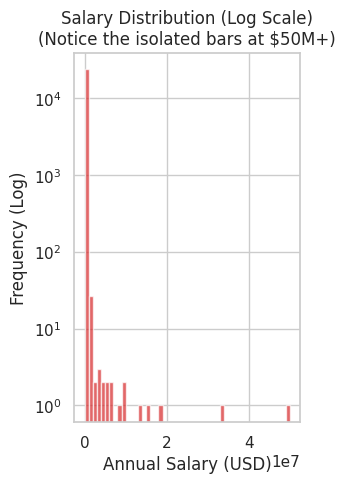

In [104]:
#Plot from student a from above --> just taken in order to not always scrole up

plt.subplot(1, 2, 1)
plt.hist(processed_data['ConvertedCompYearly'].dropna(), bins=50, color='#d62728', alpha=0.7)
plt.yscale('log')
plt.title("Salary Distribution (Log Scale)\n(Notice the isolated bars at $50M+)")
plt.xlabel("Annual Salary (USD)")
plt.ylabel("Frequency (Log)")

       ConvertedCompYearly
34267           50000000.0
28700           33552715.0
43143           18387548.0
35353           15430267.0
45971           13921760.0
48428           10000000.0
24900            9531653.0
10025            9000000.0
37352            6890299.0
30728            6371285.0
       ConvertedCompYearly
126               440856.0
40867             440856.0
26511             440000.0
13293             440000.0
20485             440000.0
45627             440000.0
22243             433975.0
12362             427300.0
39063             425000.0
14736             423454.0
Inserted executor
Inserted writer


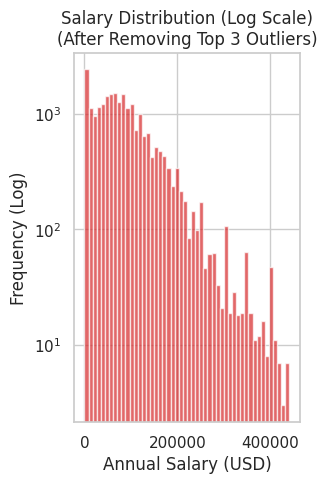

In [105]:
# Remove ConvertedCompYearly outliers 

### ATTENTION: I am create a copied dataset here in order to not mess with the original one while still testing the code ###
handle_outliers_code_writer = student_b
def removeOutliers(df: pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    dfNew = df.copy()

    #Just for validation purposes once before and once after performing the deletion of rows by the 0,99 perceptile, to see the differences as well 
    topEarners = dfNew.sort_values(by='ConvertedCompYearly', ascending=False).head(10)
    print(topEarners[['ConvertedCompYearly']])

    p99 = dfNew['ConvertedCompYearly'].quantile(0.99)  
    dfNew = dfNew[dfNew['ConvertedCompYearly'] <= p99]

    topEarners = dfNew.sort_values(by='ConvertedCompYearly', ascending=False).head(10)
    print(topEarners[['ConvertedCompYearly']])

    #Taken from studen_a
    plt.subplot(1, 2, 1)
    plt.hist(dfNew['ConvertedCompYearly'].dropna(), bins=50, color='#d62728', alpha=0.7)
    plt.yscale('log')
    plt.title("Salary Distribution (Log Scale)\n(After Removing Top 3 Outliers)")
    plt.xlabel("Annual Salary (USD)")
    plt.ylabel("Frequency (Log)")

    return dfNew


start_time_td = now()
processed_data = removeOutliers(processed_data, outliers_report)
end_time_td = now()

outlier_remover_uuid_executor = "f41b9543-cf1e-403b-9bcd-00ddd0577055"
outlier_remover_executor = [
    f':handle_outliers prov:qualifiedAssociation :{outlier_remover_uuid_executor} .',
    f':{outlier_remover_uuid_executor} prov:agent :{executed_by} .',
    f':{outlier_remover_uuid_executor} rdf:type prov:Association .',
    f':{outlier_remover_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(outlier_remover_executor, prefixes=prefixes)

print("Inserted executor")

outlier_remover_uuid_writer = "c6b8ac8d-6662-4b90-8913-1846063a3211"
td_comment2 = """
Removed the outliers with the help of the 0,99 perceptile
"""

outlier_remover_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers rdfs:label "Remove extreme salary outliers above 99th percentile" .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment2 """{td_comment2}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{outlier_remover_uuid_writer} .',
    f':{outlier_remover_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{outlier_remover_uuid_writer} rdf:type prov:Association .',
    f':{outlier_remover_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :processed_data .',
    ':cleaned_data_after_outliers rdf:type prov:Entity .',
    ':cleaned_data_after_outliers rdfs:label "Dataset after removing extreme salary outliers" .',
    ':cleaned_data_after_outliers prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data_after_outliers prov:wasDerivedFrom :processed_data .',
]
engine.insert(outlier_remover_activity, prefixes=prefixes)

print("Inserted writer")



#### 3. Inverted Logic in Rnaking Features

In [106]:
inverter_code_writer = student_b
def invertRanking(df: pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    #The following type of doing the invertion of the values may not be the best one, but as I am not the best of python programmers, it will hopefully be enough.
    mapping = {
        1: 14,
        2: 13,
        3: 12,
        4: 11,
        5: 10,
        6: 9,
        7: 8,
        8: 7,
        9: 6,
        10: 5,
        11: 4,
        12: 3,
        13: 2,
        14: 1
    }

    dfNew = df.copy()
    techEndorsCols = ["TechEndorse_4", "TechEndorse_6", "TechEndorse_8"]
    jobsatCols = ["JobSatPoints_4", "JobSatPoints_11", "JobSatPoints_6"]
    techOpposeCols = ["TechOppose_3", "TechOppose_9", "TechOppose_13"]

    columnsToInvert = techEndorsCols + jobsatCols + techOpposeCols +  ["JobSat"]

    for col in columnsToInvert:
        dfNew[col] = dfNew[col].map(mapping).fillna(0)

    return dfNew

def printRankings(df, n=5):
    #I've just taken some random samples in order to check if everything works as inteded.
    cols_to_show = ["TechEndorse_4", "JobSatPoints_11", "TechOppose_13", "JobSat"]

    print(df[cols_to_show].head(n))

printRankings(processed_data)
start_time_td = now()
processed_data = invertRanking(processed_data, outliers_report)
end_time_td = now()
printRankings(processed_data)

inverter_uuid_executor = "741afcd4-1e37-416c-b8ab-6516c5c55a7f"
inverter_executor = [
    f':invert_logic_for_ranking prov:qualifiedAssociation :{inverter_uuid_executor} .',
    f':{inverter_uuid_executor} prov:agent :{executed_by} .',
    f':{inverter_uuid_executor} rdf:type prov:Association .',
    f':{inverter_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(inverter_executor, prefixes=prefixes)

print("Inserted executor")

inverter_uuid_writer = "1d033b92-a730-4fa3-a1ea-6df3e2d3681c"
td_comment2 = """
Inverted all columns with TechEndors_*, JobSatPoints_* and JobSat in order to have it perfectly fit for the regression model.
"""

inverter_activity = [
    ':invert_logic_for_ranking rdf:type prov:Activity .',
    ':invert_logic_for_ranking rdfs:label "Invert ranking features" .',
    ':invert_logic_for_ranking sc:isPartOf :data_preparation_phase .',
    ':invert_logic_for_ranking rdfs:comment \'Data Preparation\' .', 
    f':invert_logic_for_ranking rdfs:comment2 """{td_comment2}""" .', 
    f':invert_logic_for_ranking prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':invert_logic_for_ranking prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':invert_logic_for_ranking prov:qualifiedAssociation :{inverter_uuid_writer} .',
    f':{inverter_uuid_writer} prov:agent :{inverter_code_writer} .',
    f':{inverter_uuid_writer} rdf:type prov:Association .',
    f':{inverter_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':invert_logic_for_ranking prov:used :cleaned_data_after_outliers .',
    ':data_after_invert_logic_for_ranking rdf:type prov:Entity .',
    ':data_after_invert_logic_for_ranking rdfs:label "dtaaset with inverted ranking features" .',
    ':data_after_invert_logic_for_ranking prov:wasGeneratedBy :invert_logic_for_ranking .',
    ':data_after_invert_logic_for_ranking prov:wasDerivedFrom :cleaned_data_after_outliers .',
]
engine.insert(inverter_activity, prefixes=prefixes)
print("Inserted writer")

   TechEndorse_4  JobSatPoints_11  TechOppose_13  JobSat
0            6.0              7.0           13.0    10.0
1            9.0              7.0            2.0     9.0
2            7.0              3.0            4.0     8.0
3            5.0             12.0            7.0     6.0
4            9.0              1.0            8.0     7.0
   TechEndorse_4  JobSatPoints_11  TechOppose_13  JobSat
0            9.0              8.0            2.0     5.0
1            6.0              8.0           13.0     6.0
2            8.0             12.0           11.0     7.0
3           10.0              3.0            8.0     9.0
4            6.0             14.0            7.0     8.0
Inserted executor
Inserted writer


#### 4. Ordinal Encoding

In [107]:
# Age types and how they gonna be mapped
#Under 18 years old --> 1
#18-24 years old --> 2
#25-34 years old --> 3
#35-44 years old --> 3
#45-54 years old --> 4
#55-64 years old --> 5
#65 years or older --> 6
#Prefer not to say --> 0
#NaN --> 0

def ageMapping(df: pd.DataFrame) -> pd.DataFrame:
    dfNew = df.copy()

    mapping = {
        "Under 18 years old": 1,
        "18-24 years old": 2,
        "25-34 years old": 3,
        "35-44 years old": 3,
        "45-54 years old": 4,
        "55-64 years old": 5,
        "65 years or older": 6,
        "Prefer not to say": 0
    }
    
    dfNew['AgeMapped'] = dfNew['Age'].map(mapping).fillna(0).astype(int)
    
    return dfNew

# Education levels and how they gonna be mapped
#Primary/elementary school --> 1
#Secondary school (e.g. American high school, German Realschule orGymnasium, etc.) --> 2
#Some college/university study without earning a degree --> 3
#Associate degree (A.A., A.S., etc.) --> 4
#Bachelor’s degree (B.A., B.S., B.Eng., etc.) --> 5
#Master’s degree (M.A., M.S., M.Eng., MBA, etc.) --> 6
#Professional degree (JD, MD, Ph.D, Ed.D, etc.) --> 7
# else or NaN --> 0

def educationMapping(df: pd.DataFrame) -> pd.DataFrame:
    dfNew = df.copy()

    mapping = {
        "Under 18 years old": 1,
        "Primary/elementary school": 1,
        "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": 2,
        "Some college/university study without earning a degree": 3,
        "Associate degree (A.A., A.S., etc.)": 4,
        "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": 5,
        "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": 6,
        "Professional degree (JD, MD, Ph.D, Ed.D, etc.)": 7,
    }

    dfNew["EducationLevelMapped"] = dfNew["EdLevel"].map(mapping).fillna(0).astype(int)

    return dfNew

 



# ORgSIzes and how they gonna be mapped
# Just me - I am a freelancer, sole proprietor, etc. --> 1
# Less than 20 employees --> 2
# 20 to 99 employees --> 3
# 100 to 499 employees --> 4
# 500 to 999 employees --> 5
# 1,000 to 4,999 employees --> 6
# 5,000 to 9,999 employees --> 7
# 10,000 or more employees --> 8
# I don’t know --> 0

def mapOrgSize(df: pd.DataFrame) -> pd.DataFrame:
    dfNew = df.copy()

    mapping = {
        "Just me - I am a freelancer, sole proprietor, etc.": 1,
        "Less than 20 employees": 2,
        "20 to 99 employees": 3,
        "100 to 499 employees": 4,
        "500 to 999 employees": 5,
        "1,000 to 4,999 employees": 6,
        "5,000 to 9,999 employees": 7,
        "10,000 or more employees": 8,
        "I don’t know": 0,
    }

    dfNew['OrgSizeMapped'] = dfNew['OrgSize'].map(mapping).fillna(0).astype(int)

    return dfNew

# AI usage levels and how they gonna be mapped
#Yes, I use AI tools daily --> 4
#Yes, I use AI tools weekly --> 3
#Yes, I use AI tools monthly or infrequently --> 2
#No, but I plan to soon --> 1
#No, and I don't plan to --> 0

def mapAIUsage(df: pd.DataFrame) -> pd.DataFrame:
    dfNew = df.copy()

    mapping = {
        "Yes, I use AI tools daily": 4,
        "Yes, I use AI tools weekly": 3,
        "Yes, I use AI tools monthly or infrequently": 2,
        "No, but I plan to soon": 1,
        "No, and I don't plan to": 0
    }
    
    dfNew['AISelectMapped'] = dfNew['AISelect'].map(mapping).fillna(0).astype(int)
    
    return dfNew
# AI sent# levels and how they gonna be mapped
#Very favorable --> 4
#Favorable --> 3
#Indifferent --> 2
#Unfavorable --> 1
#Very unfavorable --> 0
#Unsure --> 0

def mapAISent(df: pd.DataFrame) -> pd.DataFrame:
    dfNew = df.copy()

    mapping = {
        "Very favorable": 4,
        "Favorable": 3,
        "Indifferent": 2,
        "Unfavorable": 1,
        "Very unfavorable": 0,
        "Unsure": 0
    }

    dfNew['AISentMapped'] = dfNew['AISent'].map(mapping).fillna(0).astype(int)

    return dfNew


def printOrdinalEncoding(df, n=7):
    cols_to_show = ["Age", "AgeMapped", "EdLevel", "EducationLevelMapped", "OrgSize", "OrgSizeMapped", "AISelect", "AISelectMapped", "AISent", "AISentMapped"]

    print(df[cols_to_show].head(n))



def processAllOrdinalEncoding(df: pd.DataFrame,  outliers_report: dict) -> pd.DataFrame:
    processed_data_temp = ageMapping(processed_data)
    processed_data_temp = educationMapping(processed_data_temp)
    processed_data_temp = mapOrgSize(processed_data_temp)
    processed_data_temp = mapAIUsage(processed_data_temp)
    processed_data_temp = mapAISent(processed_data_temp)

    return processed_data_temp

start_time_td = now()
processed_data = processAllOrdinalEncoding(processed_data, outliers_report)
pd.set_option('display.expand_frame_repr', False)
printOrdinalEncoding(processed_data)
end_time_td = now()

ordinal_code_writer = student_b

ordinal_uuid_executor = "047ef8ee-059d-450f-b6d9-b53a0fd024f0"
ordinal_executor = [
    f':transform_data_from_ordinal_encoding prov:qualifiedAssociation :{ordinal_uuid_executor} .',
    f':{ordinal_uuid_executor} prov:agent :{executed_by} .',
    f':{ordinal_uuid_executor} rdf:type prov:Association .',
    f':{ordinal_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(ordinal_executor, prefixes=prefixes)

print("Inserted executor")

ordinal_uuid_writer = "b23a21dd-f992-4c77-8976-81ae9594bc96"
td_comment2 = """
transformed ordinal encoding in order to have one column for each possible value which is then ordinal encoded with values 1 to n
"""

ordinal_activity = [
    ':transform_data_from_ordinal_encoding rdf:type prov:Activity .',
    ':transform_data_from_ordinal_encoding rdfs:label "Transformed ordinal encoding" .',
    ':transform_data_from_ordinal_encoding sc:isPartOf :data_preparation_phase .',
    ':transform_data_from_ordinal_encoding rdfs:comment \'Data Preparation\' .', 
    f':transform_data_from_ordinal_encoding rdfs:comment2 """{td_comment2}""" .', 
    f':transform_data_from_ordinal_encoding prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':transform_data_from_ordinal_encoding prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':transform_data_from_ordinal_encoding prov:qualifiedAssociation :{ordinal_uuid_writer} .',
    f':{ordinal_uuid_writer} prov:agent :{ordinal_code_writer} .',
    f':{ordinal_uuid_writer} rdf:type prov:Association .',
    f':{ordinal_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':transform_data_from_ordinal_encoding prov:used :data_after_invert_logic_for_ranking .',
    ':data_after_transform_data_from_ordinal_encoding rdf:type prov:Entity .',
    ':data_after_transform_data_from_ordinal_encoding rdfs:label "dataset after ordinal encoding" .',
    ':data_after_transform_data_from_ordinal_encoding prov:wasGeneratedBy :transform_data_from_ordinal_encoding .',
    ':data_after_transform_data_from_ordinal_encoding prov:wasDerivedFrom :data_after_invert_logic_for_ranking .',
]
engine.insert(ordinal_activity, prefixes=prefixes)
print("Inserted writer")


               Age  AgeMapped                                                 EdLevel  EducationLevelMapped                   OrgSize  OrgSizeMapped                                     AISelect  AISelectMapped       AISent  AISentMapped
0  25-34 years old          3         Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                     6        20 to 99 employees              3  Yes, I use AI tools monthly or infrequently               2  Indifferent             2
1  25-34 years old          3                     Associate degree (A.A., A.S., etc.)                     4      500 to 999 employees              5                   Yes, I use AI tools weekly               3  Indifferent             2
2  35-44 years old          3            Bachelor’s degree (B.A., B.S., B.Eng., etc.)                     5                       NaN              0                    Yes, I use AI tools daily               4    Favorable             3
3  35-44 years old          3            Bachelor’s 

#### 5 Multi-Select Data

In [108]:
programmingLanguages = ["Ada", "Assembly", "Bash/Shell (allshells)", "C", "C#", "C++", "COBOL", "Dart", "Delphi", "Elixir", "Erlang", "F#", "Fortran", "GDScript", "Go", "Groovy", "HTML/CSS", "Java", "JavaScript", "Kotlin", "Lisp", "Lua", "MATLAB", "MicroPython", "OCaml", "Perl", "PHP", "PowerShell", "Prolog", "Python", "R", "Ruby", "Rust", "Scala", "SQL", "Swift", "TypeScript", "VBA", "Visual Basic (.Net)", "Zig", "Mojo", "Gleam",]
databases = ["BigQuery", "Cassandra", "Cloud Firestore", "Cosmos DB", "Databricks SQL", "Datomic", "DuckDB", "Dynamodb", "Elasticsearch", "Firebase Realtime Database", "H2", "IBM DB2", "InfluxDB", "MariaDB", "Microsoft Access", "Microsoft SQL Server", "MongoDB", "MySQL", "Neo4J", "Oracle", "PostgreSQL", "Redis", "Snowflake", "SQLite", "Supabase", "Clickhouse", "Cockroachdb", "Amazon Redshift", "Pocketbase", "Valkey"]
cloudPlattforms = ["Amazon Web Services (AWS)", "Ansible", "APT", "Bun", "Cargo", "Chocolatey", "Cloudflare", "Composer", "Datadog", "Digital Ocean", "Docker", "Firebase", "Google Cloud", "Gradle", "Heroku", "Homebrew", "IBM Cloud", "Kubernetes", "Make", "Maven (build tool)", "Microsoft Azure", "MSBuild", "Netlify", "New Relic", "Ninja", "npm", "NuGet", "Pacman", "Pip", "pnpm", "Podman", "Poetry", "Prometheus", "Railway", "Splunk", "Supabase", "Terraform", "Vercel", "Vite", "Webpack", "Yandex Cloud", "Yarn"]
webFrameworks = ["Angular", "AngularJS", "ASP.NET", "ASP.NET Core", "Astro", "Blazor", "Deno", "Django", "Drupal", "Express", "FastAPI", "Fastify", "Flask", "jQuery", "Laravel", "NestJS", "Next.js", "Node.js", "Nuxt.js", "Phoenix", "React", "Ruby on Rails", "Spring Boot", "Svelte", "Symfony", "Vue.js", "WordPress", "Axum"]
developmentEnvironments = ["Aider", "Android Studio", "Bolt", "Claude Code", "Cline and/or Roo", "Cursor", "Eclipse", "IntelliJ IDEA", "JupyterNotebook/JupyterLab", "Lovable.dev", "Nano", "Neovim", "Notepad++", "PhpStorm", "PyCharm", "Rider", "RustRover", "Sublime Text", "Trae", "Vim", "Visual Studio", "Visual Studio Code", "VSCodium", "WebStorm", "Windsurf", "Xcode", "Zed"]
operatingSystems = ["Windows", "MacOS", "Ubuntu", "Android", "Windows Subsystem for Linux (WSL)", "iOS", "Debian", "Linux (non-WSL)", "Arch", "iPadOS", "Red Hat", "Fedora", "ChromeOS", "Pop!_OS", "NixOS"]
additionalEmployments = ["Attending school (full-time)", "Attending school (part-time)", "Engaged in paid work (less than 10 hours per week)", "Engaged in paid work (10-19 hours per week)", "Engaged in paid work (20-29 hours per week)", "Transitioning to retirement (gradually reducing work hours)", "Volunteering (regularly)", "Caring for dependents (children, elderly, etc.)", "None of the above"]


def addColumns(df: pd.DataFrame,) -> pd.DataFrame:
    allColumns = programmingLanguages + databases + cloudPlattforms + webFrameworks + developmentEnvironments + operatingSystems + additionalEmployments

    for column in allColumns:
        if column not in df.columns:
            df[column] = 0
    return df

processed_data = addColumns(processed_data)


/tmp/ipykernel_958/452789767.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = 0
/tmp/ipykernel_958/452789767.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = 0
/tmp/ipykernel_958/452789767.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = 0
/tmp/ipyke

In [109]:
def programmingLanguagesToColumns(df: pd.DataFrame, source_col: str = "LanguageHaveWorkedWith", sep: str = ";") -> pd.DataFrame:
    cleaned = (
        df[source_col].fillna("").astype(str).apply(lambda s: ";".join([part.strip() for part in s.split(sep) if part.strip()]))
    )

    dummies = cleaned.str.get_dummies(sep=sep)

    for lang in programmingLanguages:
        if lang in dummies.columns:
            df[lang] = dummies[lang].astype(int)

    return df

def databasesToColumns(df: pd.DataFrame, source_col: str = "DatabaseHaveWorkedWith", sep: str = ";") -> pd.DataFrame:
    cleaned = (
        df[source_col].fillna("").astype(str).apply(lambda s: ";".join([part.strip() for part in s.split(sep) if part.strip()]))
    )

    dummies = cleaned.str.get_dummies(sep=sep)

    for lang in databases:
        if lang in dummies.columns:
            df[lang] = dummies[lang].astype(int)

    return df

def cloudPlattformsToColumns(df: pd.DataFrame, source_col: str = "PlatformHaveWorkedWith", sep: str = ";") -> pd.DataFrame:
    cleaned = (
        df[source_col].fillna("").astype(str).apply(lambda s: ";".join([part.strip() for part in s.split(sep) if part.strip()]))
    )

    dummies = cleaned.str.get_dummies(sep=sep)

    for lang in cloudPlattforms:
        if lang in dummies.columns:
            df[lang] = dummies[lang].astype(int)

    return df

def webFrameworksToColumns(df: pd.DataFrame, source_col: str = "WebframeHaveWorkedWith", sep: str = ";") -> pd.DataFrame:
    cleaned = (
        df[source_col].fillna("").astype(str).apply(lambda s: ";".join([part.strip() for part in s.split(sep) if part.strip()]))
    )

    dummies = cleaned.str.get_dummies(sep=sep)

    for lang in webFrameworks:
        if lang in dummies.columns:
            df[lang] = dummies[lang].astype(int)

    return df

def developmentEnvironmentsToColumns(df: pd.DataFrame, source_col: str = "DevEnvsHaveWorkedWith", sep: str = ";") -> pd.DataFrame:
    cleaned = (
        df[source_col].fillna("").astype(str).apply(lambda s: ";".join([part.strip() for part in s.split(sep) if part.strip()]))
    )

    dummies = cleaned.str.get_dummies(sep=sep)

    for lang in developmentEnvironments:
        if lang in dummies.columns:
            df[lang] = dummies[lang].astype(int)

    return df

def operatingSystemsToColumns(df: pd.DataFrame, source_col: str = "OpSysProfessional use", sep: str = ";") -> pd.DataFrame:
    cleaned = (
        df[source_col].fillna("").astype(str).apply(lambda s: ";".join([part.strip() for part in s.split(sep) if part.strip()]))
    )

    dummies = cleaned.str.get_dummies(sep=sep)

    for lang in operatingSystems:
        if lang in dummies.columns:
            df[lang] = dummies[lang].astype(int)

    return df

def additionalEmploymentsToColumns(df: pd.DataFrame, source_col: str = "EmploymentAddl", sep: str = ";") -> pd.DataFrame:
    cleaned = (
        df[source_col].fillna("").astype(str).apply(lambda s: ";".join([part.strip() for part in s.split(sep) if part.strip()]))
    )

    dummies = cleaned.str.get_dummies(sep=sep)

    for lang in additionalEmployments:
        if lang in dummies.columns:
            df[lang] = dummies[lang].astype(int)

    return df
def processAllMultiSelectData(df: pd.DataFrame,  outliers_report: dict) -> pd.DataFrame:
    processed_data_temp = programmingLanguagesToColumns(processed_data)
    processed_data_temp = databasesToColumns(processed_data_temp)
    processed_data_temp = cloudPlattformsToColumns(processed_data_temp)
    processed_data_temp = webFrameworksToColumns(processed_data_temp)
    processed_data_temp = developmentEnvironmentsToColumns(processed_data_temp)
    processed_data_temp = operatingSystemsToColumns(processed_data_temp)
    processed_data_temp = additionalEmploymentsToColumns(processed_data_temp)

    return processed_data_temp

start_time_td = now()
processed_data = processAllMultiSelectData(processed_data, outliers_report)
end_time_td = now()

multi_select_code_writer = student_b

multi_select_uuid_executor = "574dc9ed-a79a-4106-9f49-319be6f0b022"
multi_select_executor = [
    f':transform_data_from_multi_select prov:qualifiedAssociation :{multi_select_uuid_executor} .',
    f':{multi_select_uuid_executor} prov:agent :{executed_by} .',
    f':{multi_select_uuid_executor} rdf:type prov:Association .',
    f':{multi_select_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(multi_select_executor, prefixes=prefixes)

print("Inserted executor")

multi_select_uuid_writer = "f69e60b5-d103-4c0c-88fd-799bd0fd4de0"
td_comment2 = """
transformed multi-select similar to ordinal encoding. We have one column for each possible value which is then binary encoded with values 1 or 0. 
For non existent values like NaN, a developer got a 0 in every column. 
"""

multi_select_activity = [
    ':transform_data_from_multi_select rdf:type prov:Activity .',
    ':transform_data_from_multi_select rdfs:label "Transform multi-select datata" .',
    ':transform_data_from_multi_select sc:isPartOf :data_preparation_phase .',
    ':transform_data_from_multi_select rdfs:comment \'Data Preparation\' .', 
    f':transform_data_from_multi_select rdfs:comment2 """{td_comment2}""" .', 
    f':transform_data_from_multi_select prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':transform_data_from_multi_select prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':transform_data_from_multi_select prov:qualifiedAssociation :{multi_select_uuid_writer} .',
    f':{multi_select_uuid_writer} prov:agent :{multi_select_code_writer} .',
    f':{multi_select_uuid_writer} rdf:type prov:Association .',
    f':{multi_select_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':transform_data_from_multi_select prov:used :data_after_transform_data_from_ordinal_encoding .',
    ':data_after_transform_data_from_multi_select rdf:type prov:Entity .',
    ':data_after_transform_data_from_multi_select rdfs:label "dataset after multi select transformation" .',
    ':data_after_transform_data_from_multi_select prov:wasGeneratedBy :transform_data_from_multi_select .',
    ':data_after_transform_data_from_multi_select prov:wasDerivedFrom :data_after_transform_data_from_ordinal_encoding .',
]
engine.insert(multi_select_activity, prefixes=prefixes)
print("Inserted writer")


Inserted executor
Inserted writer


In [110]:
def printColumns(df: pd.DataFrame) -> pd.DataFrame:
    pd.set_option('display.expand_frame_repr', False)
    print(df.columns.tolist())
    print(len(df.columns))
    #colsToShow = ["LanguageHaveWorkedWith", "Dart", "Java", "Kotlin", "Python", "SQL", "Delphi", "HTML/CSS", "Bash/Shell (all shells)",] 
    #colsToShow = ["PlatformHaveWorkedWith", "Cloud Firestore", "PostgreSQL", "MongoDB", "DuckDB"]
    #colsToShow = ["PlatformHaveWorkedWith", "Amazon Web Services (AWS)", "Cloudflare", "Google Cloud", "Docker", "Firebase", "npm", "pnpm"]
    #colsToShow = ["WebframeHaveWorkedWith", "Spring Boot", "Next.js", "Node.js", "Angular", "ASP.NET"]
    colsToShow = ["DevEnvsHaveWorkedWith", "Android Studio", "Notepad++", "Visual Studio", "Visual Studio Code", "Xcode", "Eclipse"]
    #colsToShow = ["OpSysProfessional use", "Windows", "Ubuntu", "MacOS", "Windows Subsystem for Linux (WSL)"]
    #colsToShow = ["EmploymentAddl", "Attending school (full-time)", "Attending school (part-time)", "Engaged in paid work (less than 10 hours per week)", "Engaged in paid work (10-19 hours per week)", "Engaged in paid work (20-29 hours per week)", "Transitioning to retirement (gradually reducing work hours)", "Volunteering (regularly)", "Caring for dependents (children, elderly, etc.)", "None of the above"]
    #colsToShow = ["RemoteWork"]
    print(df[colsToShow].head(15))


printColumns(processed_data)

['ResponseId', 'MainBranch', 'Age', 'EdLevel', 'Employment', 'EmploymentAddl', 'WorkExp', 'LearnCodeChoose', 'LearnCode', 'LearnCodeAI', 'AILearnHow', 'YearsCode', 'DevType', 'OrgSize', 'ICorPM', 'RemoteWork', 'PurchaseInfluence', 'TechEndorseIntro', 'TechEndorse_1', 'TechEndorse_2', 'TechEndorse_3', 'TechEndorse_4', 'TechEndorse_5', 'TechEndorse_6', 'TechEndorse_7', 'TechEndorse_8', 'TechEndorse_9', 'TechEndorse_13', 'TechEndorse_13_TEXT', 'TechOppose_1', 'TechOppose_2', 'TechOppose_3', 'TechOppose_5', 'TechOppose_7', 'TechOppose_9', 'TechOppose_11', 'TechOppose_13', 'TechOppose_16', 'TechOppose_15', 'TechOppose_15_TEXT', 'Industry', 'JobSatPoints_1', 'JobSatPoints_2', 'JobSatPoints_3', 'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7', 'JobSatPoints_8', 'JobSatPoints_9', 'JobSatPoints_10', 'JobSatPoints_11', 'JobSatPoints_13', 'JobSatPoints_14', 'JobSatPoints_15', 'JobSatPoints_16', 'JobSatPoints_15_TEXT', 'AIThreat', 'NewRole', 'ToolCountWork', 'ToolCountPersona

#### 6 Categorical Data

In [111]:
MainBranch = ["I am a developer by profession", "I am not primarily a developer, but I write code sometimes as part of my work/studies", "I used to be a developer by profession, but no longer am", "I am learning to code", "I code primarily as a hobby", "I work with developers or my work supports developers but am not a developer by profession", "None of these"]
employmentStatus = ["Employed", "Independent contractor, freelancer, or self-employed", "Not employed", "Student", "Retired", "I prefer not to say"]
devTypes = ["AI/ML engineer", "Architect, software or solutions", "Cloud infrastructure engineer", "Cybersecurity or InfoSec professional", "Data engineer", "Data or business analyst", "Data scientist", "Database administrator or engineer", "Developer, AI apps or physical AI", "Developer, back-end", "Developer, desktop or enterprise applications", "Developer, embedded applications or devices", "Developer, front-end", "Developer, full-stack", "Developer, game or graphics", "Developer, mobile", "Developer, QA or test", "DevOps engineer or professional", "Founder, technology or otherwise", "Product manager", "Project manager", "Senior executive (C-suite, VP, etc.)", "Student", "Support engineer or analyst", "System administrator", "UX, Research Ops or UI design professional"]
#The following DevTypes have been excluded: Academic researcher, Applied scientist, Engineering manager, Financial analyst or engineer, Retired
devTypesToDelete = ["Academic researcher", "Applied scientist", "Engineering manager", "Financial analyst or engineer", "Retired"]
industries = ["Software Development", "Computer Systems Design and Services", "Internet, Telecomm or Information Services", "Fintech", "Energy", "Government", "Banking/Financial Services", "Manufacturing", "Transportation, or Supply Chain", "Healthcare", "Retail and Consumer Services", "Higher Education", "Media & Advertising Services", "Insurance", "Other"]
countries = ["United States of America", "Germany", "India", "United Kingdom of Great Britain and Northern Ireland", "France", "Canada", "Ukraine", "Poland", "Netherlands", "Italy", "Brazil", "Australia", "Spain", "Sweden", "Switzerland", "Czech Republic", "Austria", "Romania", "Belgium", "Other"]
remoteWork = ["Remote", "In-person", "Hybrid (some remote, leans heavy to in-person)", "Hybrid (some in-person, leans heavy to flexibility)", "Your choice (very flexible, you can come in when you want or just as needed)"]

def addColumns(df: pd.DataFrame,) -> pd.DataFrame:
    allColumns = MainBranch + employmentStatus + devTypes + industries + countries + remoteWork

    for column in allColumns:
        if column not in df.columns:
            df[column] = 0
    return df

processed_data = addColumns(processed_data)

/tmp/ipykernel_958/3823760374.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = 0
/tmp/ipykernel_958/3823760374.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = 0
/tmp/ipykernel_958/3823760374.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = 0
/tmp/ip

In [112]:
# Cell for deleting all unwatned rows regarding DevType
def deleteUnwantedDevtypes(df, source_col="DevType"):
    cleaned = df[source_col].fillna("").astype(str).str.split(";")
    
    mask_unwanted = cleaned.apply(
        lambda roles: any(item.strip() in devTypesToDelete for item in roles)
    )
    
    df = df[~mask_unwanted].copy()

    return df

def mainBranchToColumn(df: pd.DataFrame, source_col: str = "MainBranch") -> pd.DataFrame:
    unique_vals = df[source_col].dropna().unique()

    for val in unique_vals:
        df[val] = (df[source_col] == val).astype(int)

    return df

def devTypesToColumn(df: pd.DataFrame, source_col: str = "DevType") -> pd.DataFrame:
    unique_vals = df[source_col].dropna().unique()

    for val in unique_vals:
        df[val] = (df[source_col] == val).astype(int)

    return df

def employmentStatusToColumn(df: pd.DataFrame, source_col: str = "Employment") -> pd.DataFrame:
    unique_vals = df[source_col].dropna().unique()

    for val in unique_vals:
        df[val] = (df[source_col] == val).astype(int)

    return df

def industriesToColumn(df: pd.DataFrame, source_col: str = "Industry") -> pd.DataFrame:
    unique_vals = df[source_col].dropna().unique()

    for val in unique_vals:
        df[val] = (df[source_col] == val).astype(int)

    return df

def countriesToColumn(df: pd.DataFrame, source_col: str = "Country") -> pd.DataFrame:
    for val in countries:
        df[val] = (df[source_col] == val).astype(int)

    df["Other"] = df[source_col].apply(lambda x: 0 if x in countries else 1)

    return df

def remoteWorkToColumn(df: pd.DataFrame, source_col: str = "RemoteWork") -> pd.DataFrame:
    unique_vals = df[source_col].dropna().unique()

    for val in unique_vals:
        df[val] = (df[source_col] == val).astype(int)

    return df

def processAllCategoricalData(df: pd.DataFrame,  outliers_report: dict) -> pd.DataFrame:
    processed_data_temp = mainBranchToColumn(processed_data)
    processed_data_temp = employmentStatusToColumn(processed_data_temp)
    processed_data_temp = devTypesToColumn(processed_data_temp)
    processed_data_temp = industriesToColumn(processed_data_temp)
    processed_data_temp = countriesToColumn(processed_data_temp)
    processed_data_temp = remoteWorkToColumn(processed_data_temp)

    return processed_data_temp

start_time_td = now()
processed_data = processAllCategoricalData(processed_data, outliers_report)
processed_data = deleteUnwantedDevtypes(processed_data)
end_time_td = now()

categorical_code_writer = student_b

categorical_uuid_executor = "574dc9ed-a79a-4106-9f49-319be6f0b022"
categorical_executor = [
    f':transform_data_from_categorical prov:qualifiedAssociation :{categorical_uuid_executor} .',
    f':{categorical_uuid_executor} prov:agent :{executed_by} .',
    f':{categorical_uuid_executor} rdf:type prov:Association .',
    f':{categorical_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(categorical_executor, prefixes=prefixes)

print("Inserted executor")

categorical_uuid_writer = "2ccf0faa-0bda-404b-b14d-84fbb9658dff"
td_comment2 = """
Similar to the last two the columns with categorical data were also transformed in order to have a column for every single possible value. Afterwads we again applied binary encoded. For non existent values like NaN we again gave a 0 in every column. 
We further deleted the rows with DevTypes, that we do not want in our model.
"""

categorical_activity = [
    ':transform_data_from_categorical rdf:type prov:Activity .',
    ':transform_data_from_categorical rdfs:label "Transform categorical data" .',
    ':transform_data_from_categorical sc:isPartOf :data_preparation_phase .',
    ':transform_data_from_categorical rdfs:comment \'Data Preparation\' .', 
    f':transform_data_from_categorical rdfs:comment2 """{td_comment2}""" .', 
    f':transform_data_from_categorical prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':transform_data_from_categorical prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':transform_data_from_categorical prov:qualifiedAssociation :{categorical_uuid_writer} .',
    f':{categorical_uuid_writer} prov:agent :{categorical_code_writer} .',
    f':{categorical_uuid_writer} rdf:type prov:Association .',
    f':{categorical_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':transform_data_from_categorical prov:used :data_after_transform_data_from_multi_select .',
    ':data_after_transform_data_from_categorical rdf:type prov:Entity .',
    ':data_after_transform_data_from_categorical rdfs:label "dataset after categorical transformation" .',
    ':data_after_transform_data_from_categorical prov:wasGeneratedBy :transform_data_from_categorical .',
    ':data_after_transform_data_from_categorical prov:wasDerivedFrom :data_after_transform_data_from_multi_select .',
]
engine.insert(categorical_activity, prefixes=prefixes)
print("Inserted writer")

/tmp/ipykernel_958/626747772.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[val] = (df[source_col] == val).astype(int)
/tmp/ipykernel_958/626747772.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[val] = (df[source_col] == val).astype(int)
/tmp/ipykernel_958/626747772.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fr

Inserted executor
Inserted writer


In [113]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', True)


def printColumns(df: pd.DataFrame) -> pd.DataFrame:
    pd.set_option('display.expand_frame_repr', False)
    print(df.columns.tolist())
    print(len(df.columns))
    #colsToShow = ["MainBranch", "I am a developer by profession", "I am not primarily a developer, but I write code sometimes as part of my work/studies", "I used to be a developer by profession, but no longer am", "I am learning to code", "I code primarily as a hobby", "I work with developers or my work supports developers but am not a developer by profession", "None of these"]
    #colsToShow = ["Employment", "Employed", "Independent contractor, freelancer, or self-employed", "Not employed", "Student", "Retired", "I prefer not to say"]
    #colsToShow = ["DevType", "AI/ML engineer", "Architect, software or solutions", "Cloud infrastructure engineer", "Cybersecurity or InfoSec professional", "Data engineer", "Data or business analyst", "Data scientist", "Database administrator or engineer", "Developer, AI apps or physical AI", "Developer, back-end", "Developer, desktop or enterprise applications", "Developer, embedded applications or devices", "Developer, front-end", "Developer, full-stack", "Developer, game or graphics", "Developer, mobile", "Developer, QA or test", "DevOps engineer or professional", "Founder, technology or otherwise", "Product manager", "Project manager", "Senior executive (C-suite, VP, etc.)", "Student", "Support engineer or analyst", "System administrator", "UX, Research Ops or UI design professional"]
    #colsToShow = ["Industry", "Software Development", "Computer Systems Design and Services", "Internet, Telecomm or Information Services", "Fintech", "Energy", "Government", "Banking/Financial Services", "Manufacturing", "Transportation, or Supply Chain", "Healthcare", "Retail and Consumer Services", "Higher Education", "Media & Advertising Services", "Insurance", "Other"]
    #colsToShow = ["Country", "United States of America", "Germany", "India", "United Kingdom of Great Britain and Northern Ireland", "France", "Canada", "Ukraine", "Poland", "Netherlands", "Italy", "Brazil", "Australia", "Spain", "Sweden", "Switzerland", "Czech Republic", "Austria", "Romania", "Belgium", "Other"]
    colsToShow = ["RemoteWork", "Remote", "In-person", "Hybrid (some remote, leans heavy to in-person)", "Hybrid (some in-person, leans heavy to flexibility)", "Your choice (very flexible, you can come in when you want or just as needed)"]
    print(df[colsToShow].head())


printColumns(processed_data)

['ResponseId', 'MainBranch', 'Age', 'EdLevel', 'Employment', 'EmploymentAddl', 'WorkExp', 'LearnCodeChoose', 'LearnCode', 'LearnCodeAI', 'AILearnHow', 'YearsCode', 'DevType', 'OrgSize', 'ICorPM', 'RemoteWork', 'PurchaseInfluence', 'TechEndorseIntro', 'TechEndorse_1', 'TechEndorse_2', 'TechEndorse_3', 'TechEndorse_4', 'TechEndorse_5', 'TechEndorse_6', 'TechEndorse_7', 'TechEndorse_8', 'TechEndorse_9', 'TechEndorse_13', 'TechEndorse_13_TEXT', 'TechOppose_1', 'TechOppose_2', 'TechOppose_3', 'TechOppose_5', 'TechOppose_7', 'TechOppose_9', 'TechOppose_11', 'TechOppose_13', 'TechOppose_16', 'TechOppose_15', 'TechOppose_15_TEXT', 'Industry', 'JobSatPoints_1', 'JobSatPoints_2', 'JobSatPoints_3', 'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7', 'JobSatPoints_8', 'JobSatPoints_9', 'JobSatPoints_10', 'JobSatPoints_11', 'JobSatPoints_13', 'JobSatPoints_14', 'JobSatPoints_15', 'JobSatPoints_16', 'JobSatPoints_15_TEXT', 'AIThreat', 'NewRole', 'ToolCountWork', 'ToolCountPersona

#### 7 Delete not needed columns

In [114]:
def dropSelectedColumns(df: pd.DataFrame,  outliers_report: dict) -> pd.DataFrame:
    columns_to_drop = [
        "Age",
        "EdLevel",
        "OrgSize",
        "AISelect",
        "AISent",
        "LanguageHaveWorkedWith",
        "DatabaseHaveWorkedWith",
        "PlatformHaveWorkedWith",
        "WebframeHaveWorkedWith",
        "DevEnvsHaveWorkedWith",
        "OpSysProfessional use",
        "EmploymentAddl",
        "MainBranch",
        "DevType",
        "Employment",
        "Industry",
        "Country",
        "RemoteWork",
        "DevType",
        "JobSatPoints_15_TEXT",
        "LanguagesHaveEntry",
        "LanguagesWantEntry",
        "DatabaseHaveEntry",
        "DatabaseWantEntry",
        "PlatformHaveEntry",
        "PlatformWantEntry",
        "WebframeHaveEntry",
        "WebframeWantEntry",
        "DevEnvHaveEntry",
        "DevEnvWantEntry",
        "SOTagsHaveEntry",
        "SOTagsWant Entry",
        "OfficeStackHaveEntry",
        "OfficeStackWantEntry",
        "CommPlatformHaveEntr",
        "CommPlatformWantEntr",
        "AIModelsHaveEntry",
        "AIModelsWantEntry",
        "SO_Actions_15_TEXT",
        "AIAgentKnowWrite",
        "AIAgentOrchWrite",
        "AIAgentObsWrite",
        "AIAgentExtWrite",
        "AIOpen",
        "TechOppose_15_TEXT",
        "TechEndorse_13_TEXT",
    ]

    existing_cols = [c for c in columns_to_drop if c in df.columns]

    return df.drop(columns=existing_cols, errors="ignore")





start_time_td = now()
processed_data = dropSelectedColumns(processed_data, outliers_report)
end_time_td = now()

remove_not_needed_columns_code_writer = student_b

remove_not_needed_columns_uuid_executor = "a799a635-5e7c-48bd-8bfb-567de7a262f1"
remove_not_needed_columns_executor = [
    f':remove_not_needed_columns prov:qualifiedAssociation :{remove_not_needed_columns_uuid_executor} .',
    f':{remove_not_needed_columns_uuid_executor} prov:agent :{executed_by} .',
    f':{remove_not_needed_columns_uuid_executor} rdf:type prov:Association .',
    f':{remove_not_needed_columns_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(remove_not_needed_columns_executor, prefixes=prefixes)

print("Inserted executor")

remove_not_needed_columns_uuid_writer = "4873b5a0-962f-481e-ad81-d354b402767c"
td_comment2 = """
In this part we removed the rest of all columns that are not needed within our model.
"""

remove_not_needed_columns_activity = [
    ':remove_not_needed_columns rdf:type prov:Activity .',
    ':remove_not_needed_columns rdfs:label "Remove not needed columns" .',
    ':remove_not_needed_columns sc:isPartOf :data_preparation_phase .',
    ':remove_not_needed_columns rdfs:comment \'Data Preparation\' .', 
    f':remove_not_needed_columns rdfs:comment2 """{td_comment2}""" .', 
    f':remove_not_needed_columns prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':remove_not_needed_columns prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':remove_not_needed_columns prov:qualifiedAssociation :{remove_not_needed_columns_uuid_writer} .',
    f':{remove_not_needed_columns_uuid_writer} prov:agent :{remove_not_needed_columns_code_writer} .',
    f':{remove_not_needed_columns_uuid_writer} rdf:type prov:Association .',
    f':{remove_not_needed_columns_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':remove_not_needed_columns prov:used :data_after_transform_data_from_categorical .',
    ':data_after_remove_not_needed_columns rdf:type prov:Entity .',
    ':data_after_remove_not_needed_columns rdfs:label "dataset after removal of not needed columns" .',
    ':data_after_remove_not_needed_columns prov:wasGeneratedBy :remove_not_needed_columns .',
    ':data_after_remove_not_needed_columns prov:wasDerivedFrom :data_after_transform_data_from_categorical .',
]
engine.insert(remove_not_needed_columns_activity, prefixes=prefixes)
print("Inserted writer")

Inserted executor
Inserted writer


In [115]:
import os

output_dir = os.path.join("data", "prepared")
output_file = os.path.join(output_dir, "final_dataset.csv")
os.makedirs(output_dir, exist_ok=True)
processed_data.to_csv(output_file, index=False)

In [ ]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

### Describing pre-processing steps considered but not applied

**Removing Outliers**<br>
Regarding the removal of the outliers we had to separate approaches in order to handle them, one being the deletion of every row that has a salary above 500.000 per year and the second one being the deletion with the usage of perceptiles.<br>
In the end we decided against taking absolute number as a border for deletion, because it is in our opinion not wise to do that. Having absolut numbers as a salary cap me be working for now, but in the future when salaries generally rise, the border of 500.000 might be outdated and therefore could lead us to wrong decisions. With using perceptiles on the other hand, you always go with the relative flow of the numbers.

**Binning**<br>
We did not use binning at all (apart of the already "binned" columns like age) because with binning for the salaries of the developers we would have created a classification out of our regression problem, which wouldnt be advisable at all. So there haven't been any pre-processing steps been considered at all.

**Attribute removal**<br>
Regarding attribute removal we had a long discussion about which attributes to use and which to eliminate from our dataset, always debating whether these attributes would have contributed something to our problem / model or not. Especially regarding the attribute "RemoteWork", which basically listed all types of working (from fully remote to fully in the office) we had a long discussion about whether this attribute would be interesting or not. After a bit of searching through the internet we then decided to keep the attribute and therefore did not apply the step of attribute removal, as there may be an interesting correlation between remotely working and the corresponding salary.

**ONe-Hot Encoding for countries**<br>
We decided against doing one-Hot encoding for every country as it would have resulted in more than 150 columns to cover each country. We therefore decided to analyze how many countries developers are withing the Top 5, 10, 15, and 20 and then decided to go with Top-N-Encoding.

**Textual fields**<br>
We considered to go through and analyze all columns which consisted of testual answers that were given by the developers, but decided against it, as it would have been far to much to analyze and also difficult to properly encode it with the right values. Therefore we decided to drop all these attributesin order to also guarantee that we have less noisy features within our dataset. 

In [58]:
peprocessing_steps_not_applied_code_writer = student_b

preprocessing_steps_not_applied_uuid_executor = "55340241-cb18-4f1e-a6ae-651fb9b141ba"
preprocessing_steps_not_applied_executor = [
    f':preprocessing_steps_considered_but_not_applied prov:qualifiedAssociation :{preprocessing_steps_not_applied_uuid_executor} .',
    f':{preprocessing_steps_not_applied_uuid_executor} prov:agent :{executed_by} .',
    f':{preprocessing_steps_not_applied_uuid_executor} rdf:type prov:Association .',
    f':{preprocessing_steps_not_applied_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(preprocessing_steps_not_applied_executor, prefixes=prefixes)
print("Inserted executor")

td_comment2 = """Removing Outliers*
Regarding the removal of the outliers we had to separate approaches in order to handle them, one being the removal of every row that has a salary above 500.000 per year and the second one being the removal with the usage of perceptiles.<br>
In the end we decided against taking absolute number as a border for removal, because it is in our opinion not wise to do that. Having absolut numbers as a salary cap me be working for now, but in the future when salaries generally rise, the border of 500.000 might 
be outdated and therefore could lead us to wrong decisions. With using perceptiles on the other hand, you always go with the relative flow of the numbers.

Binning
We did not use binning at all (apart of the already "binned" columns like age) because with binning for the salaries of the developers we would have created a classification out of our regression problem, which wouldnt be advisable at all.
So there haven't been any pre-processing steps been considered at all.

Attribute removal
Regarding attribute removal we had a long discussion about which attributes to use and which to remove from our dataset, always debating whether these attributes would have contributed something to our problem / model or not. Especially regarding the attribute "RemoteWork",
which basically listed all types of working (from fully remote to fully in the office) we had a long discussion about whether this attribute would be interesting or not. 
After a bit of searching through the internet we then decided to keep the attribute and therefore did not apply the step of attribute removal, as there may be an interesting correlation between remotely working and the corresponding salary.

ONe-Hot Encoding for countries
We decided against doing one-Hot encoding for every country as it would have resulted in more than 150 columns to cover each country. We therefore decided to analyze how many countries developers are withing the Top 5, 10, 15, and 20 and then decided to go with Top-N-Encoding.

Textual fields
We considered to go through and analyze all columns which consisted of testual answers that were given by the developers, but decided against it, as it would have been far to much to analyze and also difficult to properly encode it with the right values.
Therefore we decided to remove all these attributesin order to also guarantee that we have less noisy features within our dataset."""

preprocessing_steps_not_applied_uuid_writer   = "b11735ff-bc57-4add-a02f-c7cec19774e3"
preprocessing_steps_not_applied_activity = [
    ':preprocessing_steps_considered_but_not_applied rdf:type prov:Activity .',
    ':preprocessing_steps_considered_but_not_applied rdfs:label "Preprocessing steps that have been considered but not applied" .',
    ':preprocessing_steps_considered_but_not_applied sc:isPartOf :data_preparation_phase .',
    ':preprocessing_steps_considered_but_not_applied rdfs:comment \'Data Preparation\' .', 
    f':preprocessing_steps_considered_but_not_applied rdfs:comment2 """{td_comment2}""" .', 
    f':preprocessing_steps_considered_but_not_applied prov:qualifiedAssociation :{preprocessing_steps_not_applied_uuid_writer} .',
    f':{preprocessing_steps_not_applied_uuid_writer} prov:agent :{peprocessing_steps_not_applied_code_writer} .',
    f':{preprocessing_steps_not_applied_uuid_writer} rdf:type prov:Association .',
    f':{preprocessing_steps_not_applied_uuid_writer} prov:hadRole :{code_writer_role} .',
    #Everything else below in my opinion not needed, as there is no Output after running these steps.
]
engine.insert(preprocessing_steps_not_applied_activity, prefixes=prefixes)
print("Inserted writer")


Inserted executor
Inserted writer


### Derived attributes

**Countries --> Regions**<br>
One possible option for making a derived attributes would have been to group countries to regions / continents. But as there are a lot of differences betweend for example western and eastern europe, we decided against it.

**Work experience in years --> seniority level**<br>
We could have created a column and classify developers based on their working experience as junioer, senior, etc. But as the Working experience is a numerical input anyway and also is "better" the higher the value is, it didn't make much sense for us. We further think, that with kind of grouping developers based on their work experience, we might create a bias which we do not want.

**Job satisfactory**<br>
Regarding the job satisfactory we also could have created derived attributes that for example say if you gave your job between 10-14 points jour job is satisfying, but with our regression problem this wouldnt have made any sense as well.

**1-to-n coding**<br>
The only real thing we did regarding the deriving of attributes was to make use of the 1-to-n encoding. As we had a lot of attributes that were either ordinal, Multi-Select or categorical, this was in our opinion the best way in order to transform the values of the affected attributes to make our dataset ready for the modelling.

In [59]:
derived_attributes_code_writer = student_b

derived_attributes_uuid_executor = "39b3d2a1-d866-4342-bc15-b02a2090a20e"
derived_attributes_executor = [
    f':derived_attributes prov:qualifiedAssociation :{derived_attributes_uuid_executor} .',
    f':{derived_attributes_uuid_executor} prov:agent :{executed_by} .',
    f':{derived_attributes_uuid_executor} rdf:type prov:Association .',
    f':{derived_attributes_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(derived_attributes_executor, prefixes=prefixes)
print("Inserted executor")

td_comment2 = """
Countries --> Regions
One possible option for making a derived attributes would have been to group countries to regions / continents. But as there are a lot of differences betweend for example western and eastern europe, we decided against it.

Work experience in years --> seniority level
We could have created a column and classify developers based on their working experience as junioer, senior, etc. But as the Working experience is a numerical input anyway and also is "better" the higher the value is,
it didn't make much sense for us. We further think, that with kind of grouping developers based on their work experience, we might create a bias which we do not want.

Job satisfactory
Regarding the job satisfactory we also could have created derived attributes that for example say if you gave your job between 10-14 points jour job is satisfying, but with our regression problem this wouldnt have made any sense as well.

1-to-n coding
The only real thing we did regarding the deriving of attributes was to make use of the 1-to-n encoding. As we had a lot of attributes that were either ordinal, Multi-Select or categorical, this was in our opinion the best way in order
to transform the values of the affected attributes to make our dataset ready for the modelling.."""

derived_attribute_uuid_writer   = "8f776548-9fd7-4b74-ae98-ada840cd6b8e"
derived_attributes_activity = [
    ':derived_attributes rdf:type prov:Activity .',
    ':derived_attributes rdfs:label "Derived attributes" .',
    ':derived_attributes sc:isPartOf :data_preparation_phase .',
    ':derived_attributes rdfs:comment \'Data Preparation\' .', 
    f':derived_attributes rdfs:comment2 """{td_comment2}""" .', 
    f':derived_attributes prov:qualifiedAssociation :{derived_attribute_uuid_writer} .',
    f':{derived_attribute_uuid_writer} prov:agent :{derived_attributes_code_writer} .',
    f':{derived_attribute_uuid_writer} rdf:type prov:Association .',
    f':{derived_attribute_uuid_writer} prov:hadRole :{code_writer_role} .',
]
engine.insert(derived_attributes_activity, prefixes=prefixes)
print("Inserted writer")

Inserted executor
Inserted writer


### External data sources

**22700+ Software Professional Salary Dataset**<br>
from Kaggle: https://www.kaggle.com/datasets/whenamancodes/software-professional-salary-dataset <br>
This could have been a good alternative to our chosen dataset, but this one only has 14 attributes and in the specification it would have been at least 15, so we wouldnt have been able to use this dataset anyways. Furthermore, this dataset does not have any attributes, that our chosen dataset wouldnt have anyway.

**Developer_Salary_By_Country**<br>
from back4app: https://www.back4app.com/database/back4app/developer-salary-by-country/api <br>
While doing our research we stumbled across this dataset right here, but in our opinion we wouldnt be able to derive some high quality model from this dataset. 

**Remote Software Developer Salaries Around the World**<br>
from arc.dev: https://arc.dev/salaries <br>
If we wanted to dive deeper into the salaries regarding developers that are working remote, this dataset would have actually been interesting for us. But like the other two datasets, we did not use them.

**Best Salary Datasets & Databases**<br>
from datarade.ai: https://datarade.ai/data-categories/salary-data/datasets <br>
This datasets also look very good on the first sight, but we would have to be very careful on using one of these datasets, because some of them only cover one country like USA. So this probably would have created a BIAS, which we obviously do not want.

In [60]:
external_data_sources_code_writer = student_b

external_data_sources_uuid_executor = "c102e7bd-8089-491e-98ff-882a90cbb1fc"
external_data_sources_executor = [
    f':external_data_sources prov:qualifiedAssociation :{external_data_sources_uuid_executor} .',
    f':{external_data_sources_uuid_executor} prov:agent :{executed_by} .',
    f':{external_data_sources_uuid_executor} rdf:type prov:Association .',
    f':{external_data_sources_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(external_data_sources_executor, prefixes=prefixes)
print("Inserted executor")

td_comment2 = """
22700+ Software Professional Salary Dataset
from Kaggle: https://www.kaggle.com/datasets/whenamancodes/software-professional-salary-dataset
This could have been a good alternative to our chosen dataset, but this one only has 14 attributes and in the specification it would have been at least 15, so we wouldnt have been able to use this dataset anyways. Furthermore, this dataset does not have any attributes, that our chosen dataset wouldnt have anyway.

Developer_Salary_By_Country
from back4app: https://www.back4app.com/database/back4app/developer-salary-by-country/api
While doing our research we stumbled across this dataset right here, but in our opinion we wouldnt be able to derive some high quality model from this dataset. 

Remote Software Developer Salaries Around the World
from arc.dev: https://arc.dev/salaries
If we wanted to dive deeper into the salaries regarding developers that are working remote, this dataset would have actually been interesting for us. But like the other two datasets, we did not use them.

Best Salary Datasets & Databases
from datarade.ai: https://datarade.ai/data-categories/salary-data/datasets
This datasets also look very good on the first sight, but we would have to be very careful on using one of these datasets, because some of them only cover one country like USA. So this probably would have created a BIAS, which we obviously do not want."""

external_data_sources_uuid_writer   = "95e51af3-81ea-44fa-ad02-cba3a157506c"
external_data_sources_activity = [
    ':external_data_sources rdf:type prov:Activity .',
    ':external_data_sources rdfs:label "External data sources" .',
    ':external_data_sources sc:isPartOf :data_preparation_phase .',
    ':external_data_sources rdfs:comment \'Data Preparation\' .', 
    f':external_data_sources rdfs:comment2 """{td_comment2}""" .', 
    f':external_data_sources prov:qualifiedAssociation :{external_data_sources_uuid_writer} .',
    f':{derived_attribute_uuid_writer} prov:agent :{external_data_sources_code_writer} .',
    f':{derived_attribute_uuid_writer} rdf:type prov:Association .',
    f':{derived_attribute_uuid_writer} prov:hadRole :{code_writer_role} .',
]
engine.insert(external_data_sources_activity, prefixes=prefixes)
print("Inserted writer")

Inserted executor
Inserted writer


## Modeling

In [ ]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [ ]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [ ]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [ ]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [ ]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [ ]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [169]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [174]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [ ]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :survey_recordset sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table

# du_query = f"""
# {prefix_header}

# SELECT DISTINCT ?name ?dtypeRaw ?descRaw WHERE {{
  # :survey_record_set cr:recordSet ?rs .
  # ?rs cr:field ?field .
  # ?field sc:name ?name .
  # ?field sc:description ?descRaw .
  # ?field cr:dataType ?dtypeRaw .
# }}
# """
# res_du = engine.query(du_query)
du_query = f"""
{prefix_header}

SELECT ?name ?dtype ?desc WHERE {{
  # Navigate from Dataset -> RecordSet -> Field
  :loaded_survey_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  
  # Fetch the properties needed for your table
  ?field sc:name ?name .
  OPTIONAL {{ ?field cr:dataType ?dtype . }}
  OPTIONAL {{ ?field sc:description ?desc . }}
}}
ORDER BY ?name
"""
"""
res_du = engine.query(du_query)
print(res_du)

du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)
"""


###################################################################################### Hier startet Part von Mav ######################################################################################

# 1. Data preparation --> Missing values
missing_values_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :handle_missing_target_values rdfs:comment2 ?comment .
}}
LIMIT 1
"""
res_td = engine.query(missing_values_query)

missing_values_comment = ""
if not res_td.empty:  # type:ignore
    comment = clean_rdf(res_td.iloc[0]["comment"])
    comment = comment.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    missing_values_comment = latex_escape(comment)

# 2. Data preparation --> Handle outliers
handle_outliers_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :handle_outliers rdfs:comment2 ?comment .
}}
LIMIT 1
"""
res_td = engine.query(handle_outliers_query)

handle_outliers_comment = ""
if not res_td.empty:  # type:ignore
    comment = clean_rdf(res_td.iloc[0]["comment"])
    comment = comment.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    handle_outliers_comment = latex_escape(comment)

# 3. Data preparation --> Invert ranking
invert_ranking_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :invert_logic_for_ranking rdfs:comment2 ?comment .
}}
LIMIT 1
"""
res_td = engine.query(invert_ranking_query)

invert_ranking_comment = ""
if not res_td.empty:  # type:ignore
    comment = clean_rdf(res_td.iloc[0]["comment"])
    comment = comment.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    invert_ranking_comment = latex_escape(comment)

# 4. Data preparation --> Ordinal encoding
ordinal_encoding_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :transform_data_from_ordinal_encoding rdfs:comment2 ?comment .
}}
LIMIT 1
"""
res_td = engine.query(ordinal_encoding_query)

ordinal_encoding_comment = ""
if not res_td.empty:  # type:ignore
    comment = clean_rdf(res_td.iloc[0]["comment"])
    comment = comment.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    ordinal_encoding_comment = latex_escape(comment)

# 5. Data preparation --> Multi-Select Data
multi_select_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :transform_data_from_multi_select rdfs:comment2 ?comment .
}}
LIMIT 1
"""
res_td = engine.query(multi_select_query)

mutli_select_comment = ""
if not res_td.empty:  # type:ignore
    comment = clean_rdf(res_td.iloc[0]["comment"])
    comment = comment.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    multi_select_comment = latex_escape(comment)

# 6. Data preparation --> categorical
categorical_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :transform_data_from_categorical rdfs:comment2 ?comment .
}}
LIMIT 1
"""
res_td = engine.query(categorical_query)

categorical_comment = ""
if not res_td.empty:  # type:ignore
    comment = clean_rdf(res_td.iloc[0]["comment"])
    comment = comment.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    categorical_comment = latex_escape(comment)

# 6. Data preparation --> not needed columns
not_needed_columns_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :remove_not_needed_columns rdfs:comment2 ?comment .
}}
LIMIT 1
"""
res_td = engine.query(not_needed_columns_query)

not_neede_columns_comment = ""
if not res_td.empty:  # type:ignore
    comment = clean_rdf(res_td.iloc[0]["comment"])
    comment = comment.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    not_needed_columns_comment = latex_escape(comment)

#Data preparation: Preprocessing steps considered but not applied.
preprocessing_steps_consideres_but_not_applied_query = f"""
{prefix_header}


SELECT ?comment WHERE {{
  :preprocessing_steps_considered_but_not_applied rdfs:comment2 ?comment .
}}
LIMIT 1
"""
res_td = engine.query(preprocessing_steps_consideres_but_not_applied_query)

preprocessing_steps_consideres_but_not_applied_comment = ""
if not res_td.empty:  # type:ignore
    comment = clean_rdf(res_td.iloc[0]["comment"])
    comment = comment.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    preprocessing_steps_consideres_but_not_applied_comment = latex_escape(comment)


#Data prepararation: Derived attributes
derived_attributes_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :derived_attributes rdfs:comment2 ?comment .
}}
LIMIT 1
"""
res_td = engine.query(derived_attributes_query)

derived_attributes_comment = ""
if not res_td.empty:  # type:ignore
    comment = clean_rdf(res_td.iloc[0]["comment"])
    comment = comment.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    derived_attributes_comment = latex_escape(comment)

#Data preparation: External data sources
external_data_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :external_data_sources rdfs:comment2 ?comment .
}}
LIMIT 1
"""
res_td = engine.query(external_data_query)

external_data_comment = ""
if not res_td.empty:  # type:ignore
    comment = clean_rdf(res_td.iloc[0]["comment"])
    comment = comment.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    external_data_comment = latex_escape(comment)


###################################################################################### Hier endet Part von Mav ######################################################################################




### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""







print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [176]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}


%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Missing values}}
{missing_values_comment}

\subsection{{Handle Outliers}}
{handle_outliers_comment}

\subsection{{Inverting Ranking}}
{invert_ranking_comment}

\subsection{{Ordinal encoding}}
{ordinal_encoding_comment}

\subsection{{Multi Select Columns transform}}
{multi_select_comment}

\subsection{{Categorical columns transform}}
{categorical_comment}

\subsection{{Removal of not needed columns}}
{not_needed_columns_comment}

\subsection{{Preprocessing steps considered but not applied}}
{preprocessing_steps_consideres_but_not_applied_comment}

\subsection{{Derived attributes}}
{derived_attributes_comment}

\subsection{{External Data Sources}}
{external_data_comment}




\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [177]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data/report/experiment_report.tex
